# Research analysis of user preferences and popularity of events on the Yandex Afisha service (June - October 2024)

## Project Description

The Yandex Afisha service provides the opportunity to book tickets for various events in Russia and Kazakhstan. Previously, a dashboard was created based on order data, which helped to notice the autumn increase in the number of orders and a simultaneous decrease in the average cost. In order to better understand the changes in user behavior and identify key trends, it is necessary to conduct an exploratory analysis of the data.

- Author: Mariia Griaznova
- Date: 08.05.2025

## Purpose and objectives of the project

**Goal:** Identify changes in user preferences and the popularity of events in the fall of 2024, analyze the behavior of users of mobile and desktop devices. Based on the data obtained, formulate recommendations, including on preparation for the winter season.

**Tasks:**
1. Download and study the structure of datasets;
2. Pre-process the data and prepare it for research;
3. Conduct exploratory data analysis:
- Analysis of the distribution of orders by segments and their seasonal changes;
- Study user activity in the fall of 2024;
- Study the distribution by regions and partners, highlight the popular ones;
4. Test hypotheses
5. Make a general conclusion and give recommendations

## Dataset structure, data exploration

### Data Description

The `final_tickets_orders_df.csv` dataset includes information about all ticket orders made from two types of devices — mobile and stationary. Includes the following fields:

- `order_id` — unique order identifier.
- `user_id` — unique user identifier.
- `created_dt_msk` — order creation date (Moscow time).
- `created_ts_msk` — order creation date and time (Moscow time).
- `event_id` — event identifier.
- `cinema_circuit` — cinema circuit. If not applicable, the value 'none' will be here.
- `age_limit` — event age limit.
- `currency_code` — payment currency (rub - rubles; kzt - tenge).
- `device_type_canonical` — the type of device from which the order was placed ("mobile" - for mobile devices, "desktop" - for desktop devices).
- `revenue` — revenue from the order.
- `service_name` — name of the ticket operator.
- `tickets_count` — number of tickets purchased.
- `total` — total order amount.
- `days_since_prev` — number of days since the previous purchase for each user. If there was no purchase, the data contains a gap.

The `final_tickets_events_df` dataset contains information about events, including the city and region of the event, as well as information about the venue of the event. The dataset contains the following fields:
- `event_id` — unique event identifier.
- `event_name` — event name.
- `event_type_description` — event type description.
- `event_type_main` — the main type of event: a theatre performance, a concert, etc.
- `organizers` — the event organizers.
- `region_name` — the name of the region.
- `city_name` — the name of the city.
- `venue_id` — the unique identifier of the venue.
- `venue_name` — the name of the venue.
- `venue_address` — the address of the venue.

The `final_tickets_tenge_df.csv` dataset contains information about the exchange rate of the tenge to the Russian ruble for 2024. The values ​​in rubles are presented for 100 tenge. The dataset contains the following fields:
- `nominal` — the face value (100 tenge).
- `data` — date.
- `curs` — the exchange rate of the tenge to the ruble.
- `cdx` — currency symbol (kzt).

### Loading data and getting to know it

In [1]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy import stats
from scipy.stats import mannwhitneyu

!pip install matplotlib-venn -q
from matplotlib_venn import venn2

Поэтапно выгрузим данные и первично изучим каждый датасет 

In [2]:
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')

display(orders_df.head(10))
display(orders_df.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,Облачко,3,8206.70,19.0
6,6636941,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,201953,нет,16,rub,desktop,917.83,Край билетов,4,9178.26,NaN
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.78,Лучшие билеты,1,955.52,NaN
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,Лучшие билеты,2,2494.73,16.0
9,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

The dataset contains 290,849 rows and 14 columns — at first glance, the data volume seems sufficient for reliable analysis.

- It will be necessary to convert `created_dt_msk` and `created_ts_msk` to `datetime` format for ease of analysis by date and time.
- `days_since_prev` has ~22 thousand gaps (these are probably the first orders of users — it is worth considering when analyzing activity).
- It will be necessary to make sure that `age_limit`, `tickets_count`, `revenue`, `total` do not have unrealistic or negative values.
- If `cinema_circuit` is always "no", it is worth excluding from analysis.

In [3]:
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')

display(events_df.head(10))
display(events_df.info())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"
5,8858,08008ffd-331c-4d77-8aad-c91691f87388,спектакль,театр,№896,Каменевский регион,Глиногорск,213,2148,"Лекции по искусству ""Хоровод"" и партнеры","пер. 50 лет Победы, д. 21 к. 90"
6,8863,2dc56536-e5ae-4d3a-9f00-f39c0ebe5b65,спектакль,театр,№3977,Медовская область,Радужсвет,47,2897,"Фестиваль уличного искусства ""Начало"" Инкорпор...","алл. Урицкого, д. 4/5 к. 1/3"
7,9041,1ab79186-41a8-420e-b618-dea51afd2c6f,спектакль,театр,№3582,Светополянский округ,Глиноград,54,3922,"Творческое агентство ""Симфония"" Лтд","бул. К.Маркса, д. 8/6"
8,9942,474ca8f8-3525-4ac0-9a98-4c1045e2fa6d,спектакль,театр,№1797,Широковская область,Радужнополье,35,3975,"Кабинет Искусств ""История"" и партнеры","пр. Гайдара, д. 4 к. 7/1"
9,9992,e36939d8-ef42-4f64-bd72-5a4199dd98f5,спектакль,театр,№1774,Тепляковская область,Горнодолинск,43,3959,"Эстетика ""Rhythm"" Инкорпорэйтед","ш. Вахитова, д. 7/8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

The dataset contains 22427 rows and 11 columns. No gaps.
- Event types (`event_type_description`, `event_type_main`) - can be used for grouping.
- Geography (`region_name`, `city_name`) - useful for analysis by region.
- `venue_address` is more of a reference information, it may be possible to delete it.
- `venue_name`, `venue_address` may need to be normalized (Inc = Incorporated, different spelling of addresses).

In [12]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

display(tenge_df.head(10))
display(tenge_df.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
5,2024-01-15,100,19.4501,kzt
6,2024-01-16,100,19.4264,kzt
7,2024-01-17,100,19.4177,kzt
8,2024-01-18,100,19.5798,kzt
9,2024-01-19,100,19.5741,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

The dataframe `tenge_df` will be needed to convert tenge to rubles. Contains 357 rows (days) and 4 columns, without data gaps.
- We will immediately convert the date in the `data` field to `datetime` for further convenient work.

In [13]:
tenge_df['data'] = pd.to_datetime(tenge_df['data'])
display(tenge_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


None

## Pre-processing and primary analysis

Let's merge `orders_df` with `events_df` to get full information about orders and events, and to work further in the full dataset with all the data we need.

In [4]:
merged_df = orders_df.merge(events_df, on='event_id', how='left')

pd.set_option('display.max_columns', None)

display(merged_df.head(10))
display(merged_df.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,Облачко,3,8206.70,19.0,9cc55c15-4375-4129-9979-3129688ba1b4,концерт,концерты,№1020,Лугоградская область,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1"
6,6636941,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,201953,нет,16,rub,desktop,917.83,Край билетов,4,9178.26,NaN,2f98d69f-4e60-4ffc-8f16-e539383526b1,спектакль,театр,№1825,Каменевский регион,Глиногорск,213.0,4035.0,"Выставка ремесел ""Платформа"" Групп","алл. Горняцкая, д. 573"
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.78,Лучшие билеты,1,955.52,NaN,0d876e01-851e-458b-ba61-753e0e0c4063,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7"
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,Лучшие билеты,2,2494.73,16.0,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7"
9,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,NaN,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерт,концерты,№1756,Широковская область,Радужнополье,35.0,4471.0,"Киновидеостудия ""Тон"" и партнеры","ул. Тихая, д. 69 стр. 669"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

None

So, our resulting dataset contains 290,849 rows and 24 columns. What is visible at first glance:
1. Gaps:
- `days_since_prev` — ~22 thousand gaps (first orders).
- `event_*`, `organizers`, `region_name`, `city_*`, `venue_*` — ~238 rows with gaps (possibly orders not linked to events, for example, "test", "error" or aggregated data). We will work with them a little later.
2. Date and time:
- `created_dt_msk` and `created_ts_msk` — fields containing the date and time of the order (Moscow time), must be converted to `datetime` for further work.
3. Categorical fields:
- Many fields containing string values, they need to be checked for extra spaces, different registers, typos and the logicality of the values ​​themselves.
4. Numeric fields:
- In general, they look adequate, you can think about reducing the bit depth.
- `age_limit` is an int type, but 0 is often used, which can mean "no limits"
5. Identifiers:
- `order_id`, `user_id`, `event_id`, `venue_id`, etc. It is necessary to check for duplicates at least by `order_id` (must be unique).

Let's look at the absences from events.

In [5]:
# Count how many rows are missing event data after merging
missing_events = merged_df['event_name'].isna().sum()

# Total size of the dataset
total_orders = merged_df.shape[0]

print(f"Total orders: {total_orders}")
print(f"Orders without event information: {missing_events}")
print(f"This is {missing_events / total_orders:.2%} of all orders")

Total orders: 290849
Orders without event information: 238
This is 0.08% of all orders


Considering that orders without event information are only 0.08% of the total number of orders, we will simply delete them.

In [6]:
# Filter rows with missing data in 'event_name' directly
merged_df = merged_df[merged_df['event_name'].notna()]

display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 290611 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290611 non-null  int64  
 1   user_id                 290611 non-null  object 
 2   created_dt_msk          290611 non-null  object 
 3   created_ts_msk          290611 non-null  object 
 4   event_id                290611 non-null  int64  
 5   cinema_circuit          290611 non-null  object 
 6   age_limit               290611 non-null  int64  
 7   currency_code           290611 non-null  object 
 8   device_type_canonical   290611 non-null  object 
 9   revenue                 290611 non-null  float64
 10  service_name            290611 non-null  object 
 11  tickets_count           290611 non-null  int64  
 12  total                   290611 non-null  float64
 13  days_since_prev         268698 non-null  float64
 14  event_name              2

None

In [7]:
initial_shape = merged_df.shape

Now our dataset has gaps only in the `days_since_prev` field. Let's move on to working with data formats.

Let's convert the `created_dt_msk` and `created_ts_msk` columns to `datetime`. And also, let's create additional `month` and `season` columns.

In [8]:
# Convert dates
merged_df['created_dt_msk'] = pd.to_datetime(merged_df['created_dt_msk'], errors='coerce')
merged_df['created_ts_msk'] = pd.to_datetime(merged_df['created_ts_msk'], errors='coerce')

# Let's create a new column 'order_month', which will contain the month the order was placed
merged_df['order_month'] = merged_df['created_dt_msk'].dt.month

In [9]:
# Comparison of months with seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'

# Add the season column
merged_df['season'] = merged_df['order_month'].apply(get_season)

merged_df[['created_dt_msk', 'order_month', 'season']].head()

,created_dt_msk,order_month,season
0,2024-08-20,8,summer
1,2024-07-23,7,summer
2,2024-10-06,10,autumn
3,2024-07-13,7,summer
4,2024-10-04,10,autumn


To recalculate revenue from an order into a single currency - rubles. Let's add the `tenge_df` dataset and create a `revenue_rub` column with revenue from an order in rubles.

In [14]:
# Join tables by date
merged_df = merged_df.merge(
    tenge_df[['data', 'curs']],
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

# Count revenue_rub
merged_df['revenue_rub'] = merged_df.apply(
    lambda row: row['revenue'] * row['curs'] / 100 if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

display(merged_df.head(10))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,order_month,season,data,curs,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",8,summer,2024-08-20,18.6972,1521.94
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",7,summer,2024-07-23,18.3419,289.45
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",10,autumn,2024-10-06,19.6475,1258.57
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",7,summer,2024-07-13,18.5010,8.49
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",10,autumn,2024-10-04,19.6648,1390.41
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,Облачко,3,8206.70,19.0,9cc55c15-4375-4129-9979-3129688ba1b4,концерт,концерты,№1020,Лугоградская область,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",10,autumn,2024-10-23,20.0531,902.74
6,6636941,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,201953,нет,16,rub,desktop,917.83,Край билетов,4,9178.26,NaN,2f98d69f-4e60-4ffc-8f16-e539383526b1,спектакль,театр,№1825,Каменевский регион,Глиногорск,213.0,4035.0,"Выставка ремесел ""Платформа"" Групп","алл. Горняцкая, д. 573",8,summer,2024-08-15,18.7730,917.83
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.78,Лучшие билеты,1,955.52,NaN,0d876e01-851e-458b-ba61-753e0e0c4063,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",9,autumn,2024-09-29,19.3741,47.78
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,Лучшие билеты,2,2494.73,16.0,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",10,autumn,2024-10-15,19.7185,74.84
9,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,NaN,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерт,концерты,№1756,Широковская область,Радужнополье,35.0,4471.0,"Киновидеостудия ""Тон"" и партнеры","ул. Тихая, д. 69 стр. 669",6,summer,2024-06-20,18.0419,1421.91


In [15]:
# Remove unnecessary columns
merged_df.drop(columns=['curs', 'data'], inplace=True)

Let's create another column `one_ticket_revenue_rub`, which will contain data on revenue from the sale of one ticket to the event.

In [16]:
merged_df['one_ticket_revenue_rub'] = merged_df.apply(
    lambda row: row['revenue_rub'] / row['tickets_count'] if row['tickets_count'] > 0 else 0, axis=1
)

display(merged_df.head(5))
display(merged_df.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,order_month,season,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",8,summer,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",7,summer,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",10,autumn,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",7,summer,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",10,autumn,1390.41,463.4700


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

None

Let's move on to working with categorical data types.

In [17]:
# Check for unique values in categorical columns
categorical_columns = ['cinema_circuit', 'currency_code', 'device_type_canonical', 'event_type_description', 'event_type_main', 'age_limit', 'season']

for column in categorical_columns:
    print(f"Unique values in column '{column}':")
    print(merged_df[column].unique())
    print()

Unique values in column 'cinema_circuit':
['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']

Unique values in column 'currency_code':
['rub' 'kzt']

Unique values in column 'device_type_canonical':
['mobile' 'desktop']

Unique values in column 'event_type_description':
['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']

Unique values in column 'event_type_main':
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']

Unique values in column 'age_limit':
[16  0 18 12  6]

Unique values in column 'season':
['summer' 'autumn']



The `cinema_circuit` and `'age_limit` columns can be transformed to make the data more understandable and easier to analyze.

In [18]:
cinema_mapping = {
    'нет': 'Не применимо',
    'Другое': 'Другие кинотеатры',
    'Киномакс': 'Киномакс',
    'КиноСити': 'КиноСити',
    'Москино': 'Москино',
    'ЦентрФильм': 'ЦентрФильм'
}

age_mapping = {
    0: 'Все возрастные группы',
    6: '6+',
    12: '12+',
    16: '16+',
    18: '18+'
}

merged_df['cinema_circuit'] = merged_df['cinema_circuit'].map(cinema_mapping)
merged_df['age_limit'] = merged_df['age_limit'].map(age_mapping)

In [19]:
# Convert columns to categorical data type
merged_df[categorical_columns] = merged_df[categorical_columns].apply(pd.Categorical)

Let's move on to working with numerical data.

In [20]:
# Separate data by currencies with creation of independent copies
df_rub = merged_df[merged_df['currency_code'] == 'rub'].copy()
df_kzt = merged_df[merged_df['currency_code'] == 'kzt'].copy()

In [21]:
# Check the main statistics for revenue and tickets_count in rubles and tenge
rub_stats = df_rub[['revenue', 'tickets_count']].describe()
kzt_stats = df_kzt[['revenue', 'tickets_count']].describe()

# Add captions to tables
print("Key statistics for ruble data (rub):\n")
display(rub_stats)

print("Key statistics for tenge data (kzt):\n")
display(kzt_stats)

Key statistics for ruble data (rub):



,revenue,tickets_count
count,285542.000000,285542.000000
mean,548.013929,2.754159
std,871.750181,1.171575
min,-90.760000,1.000000
25%,114.170000,2.000000
50%,346.630000,3.000000
75%,793.320000,4.000000
max,81174.540000,57.000000


Key statistics for tenge data (kzt):



,revenue,tickets_count
count,5069.000000,5069.000000
mean,4995.206767,2.762872
std,4916.752776,1.115558
min,0.000000,1.000000
25%,518.100000,2.000000
50%,3698.830000,3.000000
75%,7397.660000,4.000000
max,26425.860000,6.000000


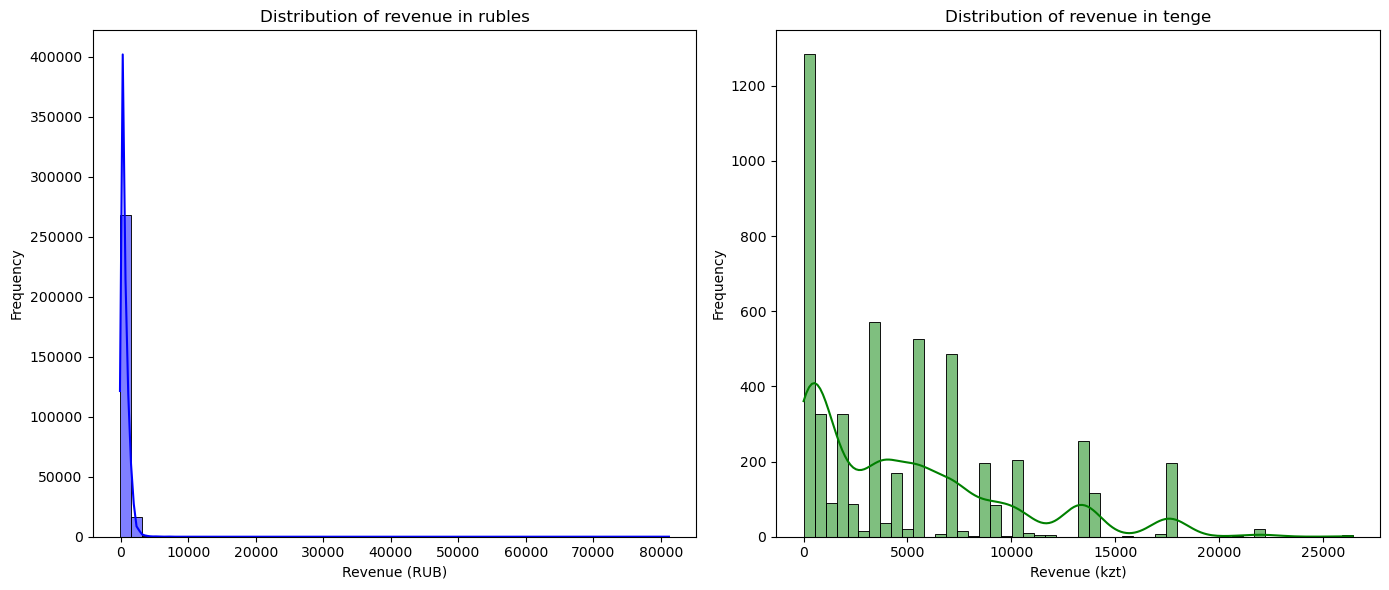

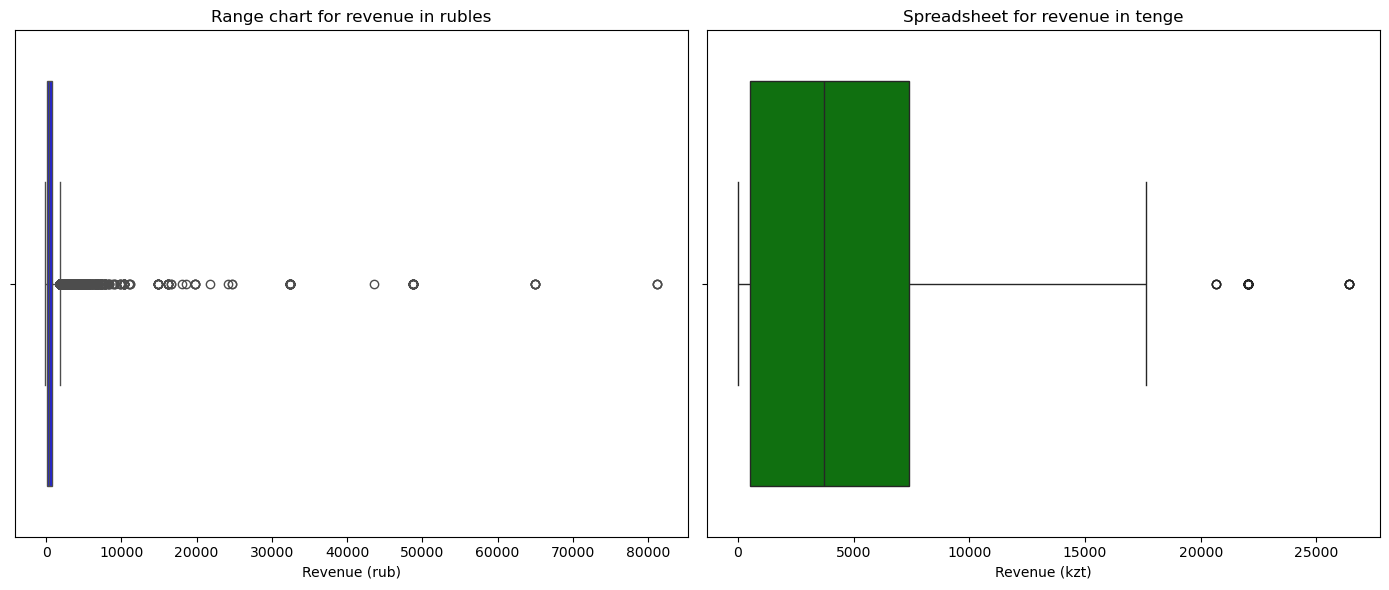

In [22]:
# Settings for charts
plt.figure(figsize=(14, 6))

# Histogram for revenue in rubles
plt.subplot(1, 2, 1)
sns.histplot(df_rub['revenue'], kde=True, color='blue', bins=50)
plt.title('Distribution of revenue in rubles')
plt.xlabel('Revenue (RUB)')
plt.ylabel('Frequency')

# Histogram for revenue in tenge
plt.subplot(1, 2, 2)
sns.histplot(df_kzt['revenue'], kde=True, color='green', bins=50)
plt.title('Distribution of revenue in tenge')
plt.xlabel('Revenue (kzt)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Settings for charts
plt.figure(figsize=(14, 6))

# Boxplot for revenue in rubles
plt.subplot(1, 2, 1)
sns.boxplot(x=df_rub['revenue'], color='blue')
plt.title('Range chart for revenue in rubles')
plt.xlabel('Revenue (rub)')

# Boxplot for revenue in tenge
plt.subplot(1, 2, 2)
sns.boxplot(x=df_kzt['revenue'], color='green')
plt.title('Spreadsheet for revenue in tenge')
plt.xlabel('Revenue (kzt)')

plt.tight_layout()
plt.show()


**For ruble data (rub):**

Revenue:
- Minimum value: -90.76 (negative value, which does not make sense in the context of revenue, most likely this is a return or error).
- Maximum value: 81,174.54 (this is probably an outlier).

Number of tickets (tickets_count):
- Minimum value: 1 (this is a normal minimum value).
- Maximum value: 57 (in general, it seems that the number of tickets should not be very high, but this \ could be a large group order, for example, organized for school students).

**For tenge data (kzt):**

Revenue:
- Minimum value: 0 (zero is also possible if there was no revenue from the order, for example, due to a return or some kind of promotional/gift offer).
- Maximum value: 26,425.86 (in general, this value also looks quite high for tenge).

Number of tickets (tickets_count):
- Minimum value: 1 (this is a normal minimum value).
- Maximum value: 6 (also looks quite normal).

So, based on the statistics, we can say that negative values ​​in revenue for ruble data are clearly an error. We should remove them. Very large revenue values ​​in rubles are probably outliers, and it is worth limiting them to the 99th percentile. The number of tickets in rubles can reach 57, which is very different from the usual values, but this can be a very real large order, so we will not touch the data on the number of tickets.

In [23]:
# Remove data with negative revenue in rubles
merged_df = merged_df[(merged_df['currency_code'] != 'rub') | (merged_df['revenue'] >= 0)]

# Let's limit revenue to the 99th percentile
percentile_99_rub = merged_df[merged_df['currency_code'] == 'rub']['revenue'].quantile(0.99)
percentile_99_kzt = merged_df[merged_df['currency_code'] == 'kzt']['revenue'].quantile(0.99)

# Filter revenue data for each currency
merged_df = merged_df[(merged_df['currency_code'] != 'rub') | (merged_df['revenue'] <= percentile_99_rub)]
merged_df = merged_df[(merged_df['currency_code'] != 'kzt') | (merged_df['revenue'] <= percentile_99_kzt)]

Let's look at the statistics after removing outliers.

In [24]:
# Let's check the main statistics on the updated data
rub_stats_updated = merged_df[merged_df['currency_code'] == 'rub'][['revenue', 'tickets_count']].describe()
kzt_stats_updated = merged_df[merged_df['currency_code'] == 'kzt'][['revenue', 'tickets_count']].describe()

print("Main statistics for ruble data (rub) after updates:\n")
display(rub_stats_updated)

print("Key statistics for tenge data (kzt) after updates:\n")
display(kzt_stats_updated)

Main statistics for ruble data (rub) after updates:



,revenue,tickets_count
count,282361.000000,282361.000000
mean,511.501020,2.740913
std,500.914811,1.163546
min,0.000000,1.000000
25%,113.020000,2.000000
50%,341.710000,3.000000
75%,782.410000,3.000000
max,2570.800000,57.000000


Key statistics for tenge data (kzt) after updates:



,revenue,tickets_count
count,5040.000000,5040.000000
mean,4893.669063,2.748413
std,4742.680176,1.101784
min,0.000000,1.000000
25%,515.350000,2.000000
50%,3698.830000,3.000000
75%,7397.660000,3.000000
max,17617.240000,6.000000


The statistics now look more reasonable. Revenue and ticket sales generally look within reasonable limits, and significant outliers have been eliminated.

Let's also analyze the values in the `total` column.

In [25]:
# Basic statistics for total
rub_total_stats = df_rub['total'].describe()
kzt_total_stats = df_kzt['total'].describe()

print("Basic statistics on the total order amount (total) in rubles:\n")
display(rub_total_stats)

print("Basic statistics on the total order amount (total) in tenge:\n")
display(kzt_total_stats)

Basic statistics on the total order amount (total) in rubles:



count    285542.000000
mean       6330.621221
std        8619.327495
min        -358.850000
25%        2120.070000
50%        4673.850000
75%        8783.220000
max      811745.400000
Name: total, dtype: float64

Basic statistics on the total order amount (total) in tenge:



count      5069.000000
mean      75236.969067
std       68039.218885
min           0.000000
25%        9353.700000
50%       61647.160000
75%      114868.830000
max      344606.500000
Name: total, dtype: float64

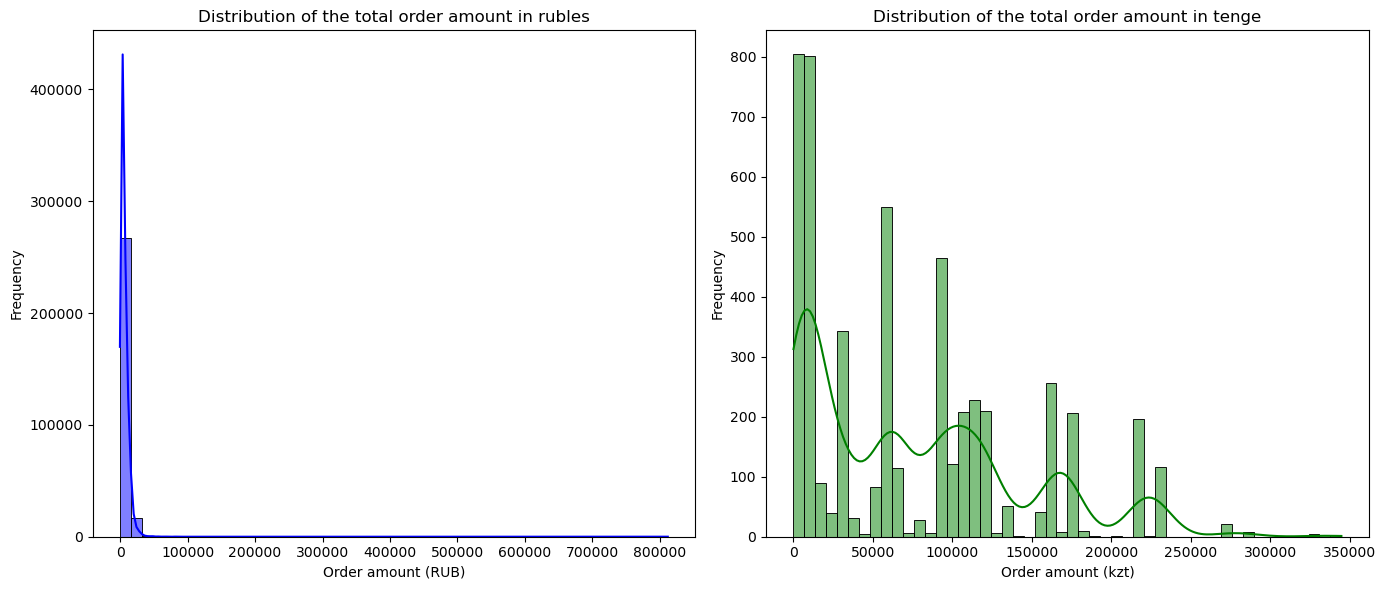

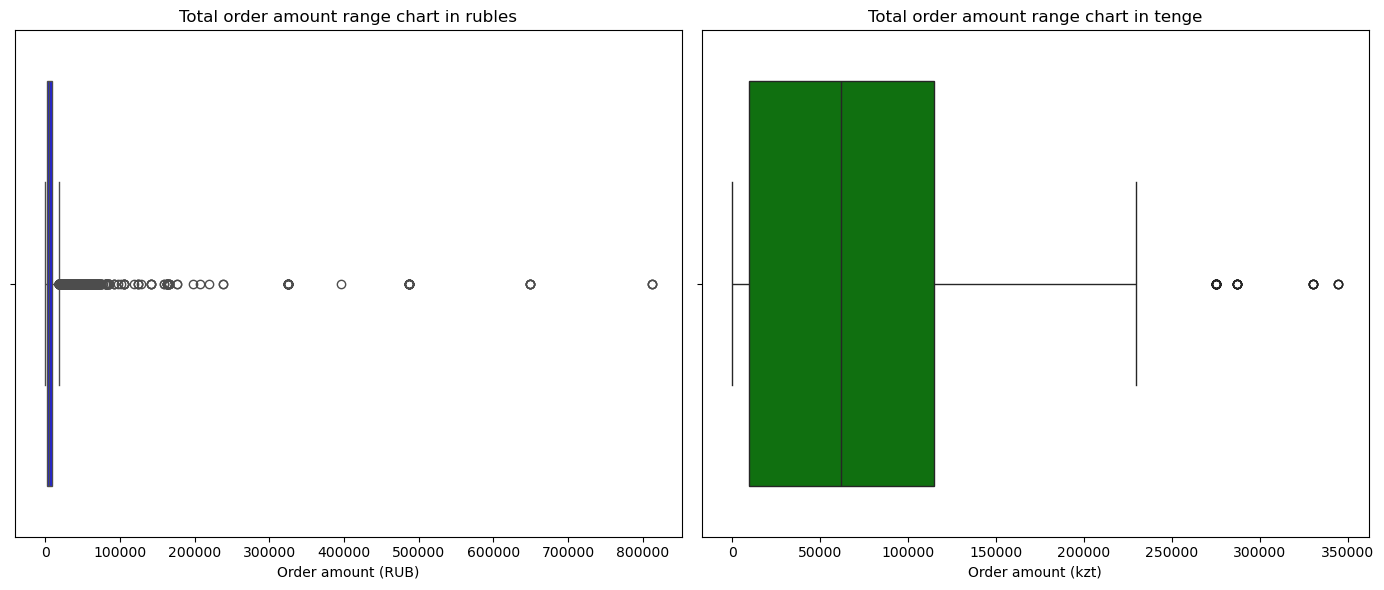

In [27]:
# Settings for charts
plt.figure(figsize=(14, 6))

# Histogram for total order amount in rubles
plt.subplot(1, 2, 1)
sns.histplot(df_rub['total'], kde=True, color='blue', bins=50)
plt.title('Distribution of the total order amount in rubles')
plt.xlabel('Order amount (RUB)')
plt.ylabel('Frequency')

# Histogram for total order amount in tenge
plt.subplot(1, 2, 2)
sns.histplot(df_kzt['total'], kde=True, color='green', bins=50)
plt.title('Distribution of the total order amount in tenge')
plt.xlabel('Order amount (kzt)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Settings for charts
plt.figure(figsize=(14, 6))

# Boxplot for total order amount in rubles
plt.subplot(1, 2, 1)
sns.boxplot(x=df_rub['total'], color='blue')
plt.title('Total order amount range chart in rubles')
plt.xlabel('Order amount (RUB)')

# Boxplot for total order amount in tenge
plt.subplot(1, 2, 2)
sns.boxplot(x=df_kzt['total'], color='green')
plt.title('Total order amount range chart in tenge')
plt.xlabel('Order amount (kzt)')

plt.tight_layout()
plt.show()

**Total order amount in rubles:**
- Average: 6330 ₽, median: 4674 ₽.
- Standard deviation is very high: 8619 ₽ — significant spread.
- Minimum — negative value (-359 ₽), which is incorrect for the total order amount.
- Maximum — 811745 ₽ — suspiciously high amount (possibly an error or corporate order).

**Total order amount in tenge**
- Average: 75237 ₸, median: 61647 ₸.
- Maximum — 344606 ₸.
- Zero values — possible, similar to revenue.

It is definitely worth deleting lines with total < 0. You can also trim by the 99th percentile similar to `revenue` to remove extreme values.

In [28]:
# Remove data with negative order amount in rubles
merged_df = merged_df[(merged_df['currency_code'] != 'rub') | (merged_df['total'] >= 0)]

# Limit the order amount to the 99th percentile
percentile_99_rub_total = merged_df[merged_df['currency_code'] == 'rub']['total'].quantile(0.99)
percentile_99_kzt_total = merged_df[merged_df['currency_code'] == 'kzt']['total'].quantile(0.99)

# Filter data by order amount for each currency
merged_df = merged_df[(merged_df['currency_code'] != 'rub') | (merged_df['total'] <= percentile_99_rub_total)]
merged_df = merged_df[(merged_df['currency_code'] != 'kzt') | (merged_df['total'] <= percentile_99_kzt_total)]

In [29]:
# Let's split the updated data by currencies
rub_total_stats = merged_df[merged_df['currency_code'] == 'rub']['total'].describe()
kzt_total_stats = merged_df[merged_df['currency_code'] == 'kzt']['total'].describe()

print("Basic statistics on the total order amount (total) in rubles after filtering:\n")
display(rub_total_stats)

print("Basic statistics on the total order amount (total) in tenge after filtering:\n")
display(kzt_total_stats)

Basic statistics on the total order amount (total) in rubles after filtering:



count    279604.000000
mean       5818.203923
std        4706.530841
min           0.000000
25%        2091.510000
50%        4539.265000
75%        8512.220000
max       22472.790000
Name: total, dtype: float64

Basic statistics on the total order amount (total) in tenge after filtering:



count      5032.000000
mean      73651.177663
std       65684.760207
min           0.000000
25%        9329.050000
50%       61647.160000
75%      114868.830000
max      229737.660000
Name: total, dtype: float64

After filtering, the total order amount data looks much more realistic:
- Removed negative values in rubles.
- Limited outliers at the 99th percentile for both currencies.

The average value and standard deviation in rubles decreased, indicating a decrease in the impact of outliers. In tenge, the picture also became a little "smoother" - the maximum values significantly decreased (from 344606 to 229737).

We optimize the bit depth of those numeric columns where possible.

In [30]:
# Function for optimizing numeric columns
def reduce_numeric_memory_usage(df, verbose=True):
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.select_dtypes(include=['int', 'float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if pd.api.types.is_integer_dtype(df[col]):
            if col_min >= 0:
                if col_max < 255:
                    df[col] = df[col].astype('uint8')
                elif col_max < 65535:
                    df[col] = df[col].astype('uint16')
                elif col_max < 4294967295:
                    df[col] = df[col].astype('uint32')
                else:
                    df[col] = df[col].astype('uint64')
            else:
                if col_min > -128 and col_max < 127:
                    df[col] = df[col].astype('int8')
                elif col_min > -32768 and col_max < 32767:
                    df[col] = df[col].astype('int16')
                elif col_min > -2147483648 and col_max < 2147483647:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
        else:
            df[col] = df[col].astype('float32')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Память до: {start_mem:.2f} MB')
        print(f'Память после: {end_mem:.2f} MB')
        print(f'Сэкономлено: {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

In [31]:
merged_df = reduce_numeric_memory_usage(merged_df)

Память до: 237.50 MB
Память после: 225.02 MB
Сэкономлено: 5.3%


In [32]:
display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 284636 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                284636 non-null  uint32        
 1   user_id                 284636 non-null  object        
 2   created_dt_msk          284636 non-null  datetime64[ns]
 3   created_ts_msk          284636 non-null  datetime64[ns]
 4   event_id                284636 non-null  uint32        
 5   cinema_circuit          284636 non-null  category      
 6   age_limit               284636 non-null  category      
 7   currency_code           284636 non-null  category      
 8   device_type_canonical   284636 non-null  category      
 9   revenue                 284636 non-null  float32       
 10  service_name            284636 non-null  object        
 11  tickets_count           284636 non-null  uint8         
 12  total                   284636 non-

None

Let's move on to working with duplicates

In [33]:
# Check for obvious duplicates
merged_df.duplicated().sum()

0

In [34]:
merged_df.duplicated(subset=['order_id']).sum()

0

No obvious duplicates were found, as well as duplicates by `order_id`. Now it is important to check for duplicates by ticket booking, for this we will see if there are duplicate entries by all other columns except `order_id`.

In [35]:
# Define a list of columns by which we search for duplicates (all except order_id)
dup_columns = [col for col in merged_df.columns if col != 'order_id']

# Find potential implicit duplicates
duplicates_df = merged_df[merged_df.duplicated(subset=dup_columns, keep=False)].copy()

# Sorting for clarity
duplicates_df = duplicates_df.sort_values(by=['user_id', 'event_id', 'created_ts_msk'])

display(duplicates_df)
print(f"Number of potential implicit duplicates: {duplicates_df.shape[0]}")

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,order_month,season,revenue_rub,one_ticket_revenue_rub
11759,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,Не применимо,18+,rub,mobile,69.820000,Билеты в руки,1,997.479980,0.0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",8,summer,69.820000,69.820000
11760,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,Не применимо,18+,rub,mobile,69.820000,Билеты в руки,1,997.479980,0.0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",8,summer,69.820000,69.820000
57173,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,Не применимо,6+,rub,mobile,11.230000,Лови билет!,2,280.809998,0.0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",10,autumn,11.230000,5.615000
57176,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,Не применимо,6+,rub,mobile,11.230000,Лови билет!,2,280.809998,0.0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",10,autumn,11.230000,5.615000
83932,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,Не применимо,6+,rub,mobile,59.189999,Билеты в руки,3,739.849976,0.0,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",6,summer,59.189999,19.730000
83937,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,Не применимо,6+,rub,mobile,59.189999,Билеты в руки,3,739.849976,0.0,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",6,summer,59.189999,19.730000
148347,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,Не применимо,Все возрастные группы,rub,mobile,26.959999,Лучшие билеты,4,674.119995,0.0,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",10,autumn,26.959999,6.740000
148351,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,Не применимо,Все возрастные группы,rub,mobile,26.959999,Лучшие билеты,4,674.119995,0.0,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",10,autumn,26.959999,6.740000
154042,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,Не применимо,6+,rub,mobile,126.839996,Билеты без проблем,1,3170.949951,0.0,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",8,summer,126.839996,126.839996
154045,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,Не применимо,6+,rub,mobile,126.839996,Билеты без проблем,1,3170.949951,0.0,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",8,summer,126.839996,126.839996


Number of potential implicit duplicates: 58


We received a total of 58 duplicates, we will leave only 1 entry for each booking.

In [36]:
# Remove implicit duplicates, leaving the first record
merged_df = merged_df.drop_duplicates(subset=dup_columns, keep='first').copy()

The preprocessing process can be considered complete, let's check the resulting dataset before moving on to research work.

In [38]:
final_shape = merged_df.shape
rows_removed = initial_shape[0] - final_shape[0]
percentage_removed = (rows_removed / initial_shape[0]) * 100

display(merged_df.head(10))
display(merged_df.info())

print(f"Initial number of lines: {initial_shape[0]}")
print(f"Final number of lines: {final_shape[0]}")
print(f"Lines removed: {rows_removed} ({percentage_removed:.2f}%)")

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,order_month,season,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,Не применимо,16+,rub,mobile,1521.939941,Край билетов,4,10870.990234,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",8,summer,1521.939941,380.484985
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,Не применимо,Все возрастные группы,rub,mobile,289.450012,Мой билет,2,2067.510010,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",7,summer,289.450012,144.725006
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,Не применимо,Все возрастные группы,rub,mobile,1258.569946,За билетом!,4,13984.160156,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",10,autumn,1258.569946,314.642487
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,Не применимо,Все возрастные группы,rub,mobile,8.490000,Лови билет!,2,212.279999,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",7,summer,8.490000,4.245000
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,Не применимо,18+,rub,mobile,1390.410034,Билеты без проблем,3,10695.429688,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",10,autumn,1390.410034,463.470001
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,Не применимо,12+,rub,mobile,902.739990,Облачко,3,8206.700195,19.0,9cc55c15-4375-4129-9979-3129688ba1b4,концерт,концерты,№1020,Лугоградская область,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",10,autumn,902.739990,300.913330
6,6636941,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,201953,Не применимо,16+,rub,desktop,917.830017,Край билетов,4,9178.259766,NaN,2f98d69f-4e60-4ffc-8f16-e539383526b1,спектакль,театр,№1825,Каменевский регион,Глиногорск,213.0,4035.0,"Выставка ремесел ""Платформа"" Групп","алл. Горняцкая, д. 573",8,summer,917.830017,229.457504
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,Не применимо,12+,rub,mobile,47.779999,Лучшие билеты,1,955.520020,NaN,0d876e01-851e-458b-ba61-753e0e0c4063,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",9,autumn,47.779999,47.779999
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,Не применимо,12+,rub,mobile,74.839996,Лучшие билеты,2,2494.729980,16.0,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,спектакль,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",10,autumn,74.839996,37.419998
9,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,Не применимо,12+,rub,mobile,1421.910034,Лови билет!,4,17773.869141,NaN,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерт,концерты,№1756,Широковская область,Радужнополье,35.0,4471.0,"Киновидеостудия ""Тон"" и партнеры","ул. Тихая, д. 69 стр. 669",6,summer,1421.910034,355.477509


<class 'pandas.core.frame.DataFrame'>
Index: 284606 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                284606 non-null  uint32        
 1   user_id                 284606 non-null  object        
 2   created_dt_msk          284606 non-null  datetime64[ns]
 3   created_ts_msk          284606 non-null  datetime64[ns]
 4   event_id                284606 non-null  uint32        
 5   cinema_circuit          284606 non-null  category      
 6   age_limit               284606 non-null  category      
 7   currency_code           284606 non-null  category      
 8   device_type_canonical   284606 non-null  category      
 9   revenue                 284606 non-null  float32       
 10  service_name            284606 non-null  object        
 11  tickets_count           284606 non-null  uint8         
 12  total                   284606 non-

None

Initial number of lines: 290611
Final number of lines: 284606
Lines removed: 6005 (2.07%)


### Intermediate output

1. Loading and preliminary acquaintance with the data.

Three datasets were loaded:
- `orders_df` with information about orders (290 849 rows, 14 columns). We made sure that the only gaps were in the 'days_since_prev' column (approximately 22 thousand gaps), which is associated with the first orders.
- `events_df` with information about events (22 427 rows, 11 columns). It will help to associate orders with specific events.
- `tenge_df` auxiliary dataset with information about exchange rates for converting tenge to rubles (357 rows, 4 columns).

2. Data Merging:
- We merged the `orders_df` and `events_df` datasets, obtaining a final dataframe with 290 849 rows and 24 columns, which allowed us to work with full order and event data. We removed records without event information (0.08% of all orders).

3. Data Transformations:
- Converted the 'created_dt_msk' and 'created_ts_msk' columns to `datetime` format.
- Created additional columns for analysis: order month ('order_month') and season ('season').
- To convert revenue to rubles, we used the `tenge_df` table, joined by date and converted revenue to rubles 'revenue_rub', also added the column 'one_ticket_revenue_rub' with information on revenue from one ticket.

4. Gaps and outliers analysis:
- Gaps in the 'days_since_prev' and events columns were processed: gaps in the event were removed, and gaps in 'days_since_prev' were left for the analysis of primary orders.
- Outliers were identified in the columns with numerical data ('revenue', 'tickets_count', 'total'): Negative values ​​in 'revenue' and 'total' were removed. Very large values ​​were limited to the 99th percentile to exclude anomalies.
- After filtering, the data became more adequate, and the statistics showed more stable values.

5. Data optimization:
- Reducing the bit depth of numerical columns allowed us to save about 5% of memory, which increased the efficiency of working with data.
- Highlighted categorical columns: 'cinema_circuit', 'currency_code', 'device_type_canonical', 'event_type_description', 'event_type_main', 'age_limit', 'season'

6. Duplicate analysis:
- Checks for duplicates of ticket bookings were performed by all attributes except `order_id`, and 58 duplicates were found. Only the first record for each duplicate was left for further analysis.

Thus, 6 005 rows were deleted during data preprocessing, which is 2.07% of the original data volume.

## Exploratory data analysis

### Analysis of order distribution by segments and their seasonal changes

First, let's calculate the number of orders for each month from June to October 2024 to see the dynamics.

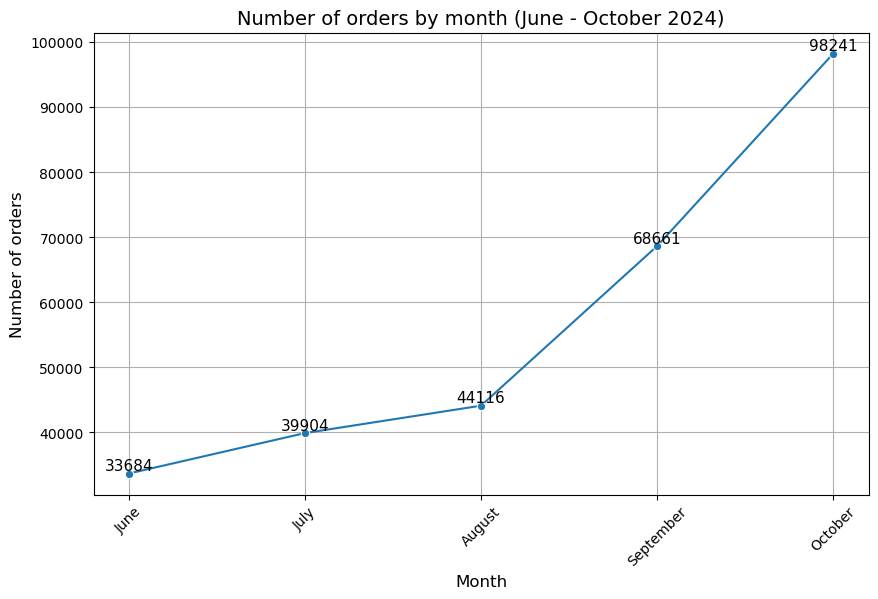

,Month,Total Orders
0,6,33684
1,7,39904
2,8,44116
3,9,68661
4,10,98241


In [39]:
# Grouping data by month and counting the number of orders
orders_by_month = merged_df.groupby('order_month')['order_id'].count().reset_index().copy()

# Rename columns for convenience
orders_by_month.columns = ['Month', 'Total Orders']

# Visualization of results
plt.figure(figsize=(10, 6))
sns.lineplot(data=orders_by_month, x='Month', y='Total Orders', marker='o')

# Add labels for each point
for i in range(len(orders_by_month)):
    plt.text(x=orders_by_month['Month'][i], 
             y=orders_by_month['Total Orders'][i] + 500,
             s=str(orders_by_month['Total Orders'][i]),
             ha='center', fontsize=11)

plt.title('Number of orders by month (June - October 2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of orders', fontsize=12)
plt.xticks(ticks=orders_by_month['Month'], labels=['June', 'July', 'August', 'September', 'October'], rotation=45)
plt.grid(True)
plt.show()

display(orders_by_month)

It is clear that with the onset of autumn there is indeed an increase in the number of orders, compared to the summer months.

Let's move on to studying the distribution of orders by type of event, type of device and category of event by age rating for the summer and autumn periods, we will use the shares of orders for each segment.

In [40]:
# Filter data by season
summer_df = merged_df[merged_df['season'] == 'summer'].copy()
autumn_df = merged_df[merged_df['season'] == 'autumn'].copy()

# Function for calculating shares for each segment with rounding
def calculate_segment_distribution(df, column):
    segment_counts = df[column].value_counts(normalize=True).round(2)
    return segment_counts

# For the summer season
summer_event_type_dist = calculate_segment_distribution(summer_df, 'event_type_main')
summer_device_type_dist = calculate_segment_distribution(summer_df, 'device_type_canonical')
summer_age_limit_dist = calculate_segment_distribution(summer_df, 'age_limit')

# For the autumn season
autumn_event_type_dist = calculate_segment_distribution(autumn_df, 'event_type_main')
autumn_device_type_dist = calculate_segment_distribution(autumn_df, 'device_type_canonical')
autumn_age_limit_dist = calculate_segment_distribution(autumn_df, 'age_limit')

# Print shares for verification
display("Summer period - event type:", summer_event_type_dist)
display("Autumn period - type of event:", autumn_event_type_dist)
display("Summer period - device type:", summer_device_type_dist)
display("Autumn period - device type:", autumn_device_type_dist)
display("Summer period - event category by age limit:", summer_age_limit_dist)
display("Autumn period - event category by age limit:", autumn_age_limit_dist)

'Summer period - event type:'

event_type_main
концерты    0.42
другое      0.27
театр       0.20
стендап     0.05
спорт       0.03
выставки    0.02
ёлки        0.00
Name: proportion, dtype: float64

'Autumn period - type of event:'

event_type_main
концерты    0.37
театр       0.25
другое      0.20
спорт       0.11
стендап     0.04
выставки    0.01
ёлки        0.01
Name: proportion, dtype: float64

'Summer period - device type:'

device_type_canonical
mobile     0.81
desktop    0.19
Name: proportion, dtype: float64

'Autumn period - device type:'

device_type_canonical
mobile     0.8
desktop    0.2
Name: proportion, dtype: float64

'Summer period - event category by age limit:'

age_limit
16+                      0.28
12+                      0.21
6+                       0.18
Все возрастные группы    0.18
18+                      0.15
Name: proportion, dtype: float64

'Autumn period - event category by age limit:'

age_limit
16+                      0.26
Все возрастные группы    0.24
12+                      0.22
6+                       0.18
18+                      0.10
Name: proportion, dtype: float64

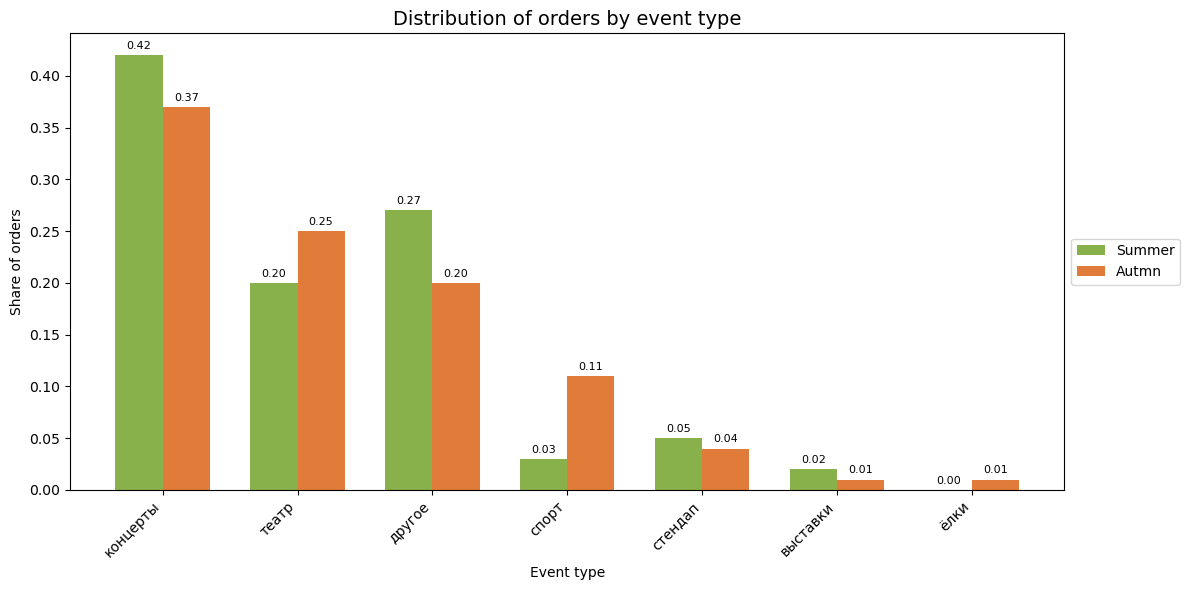

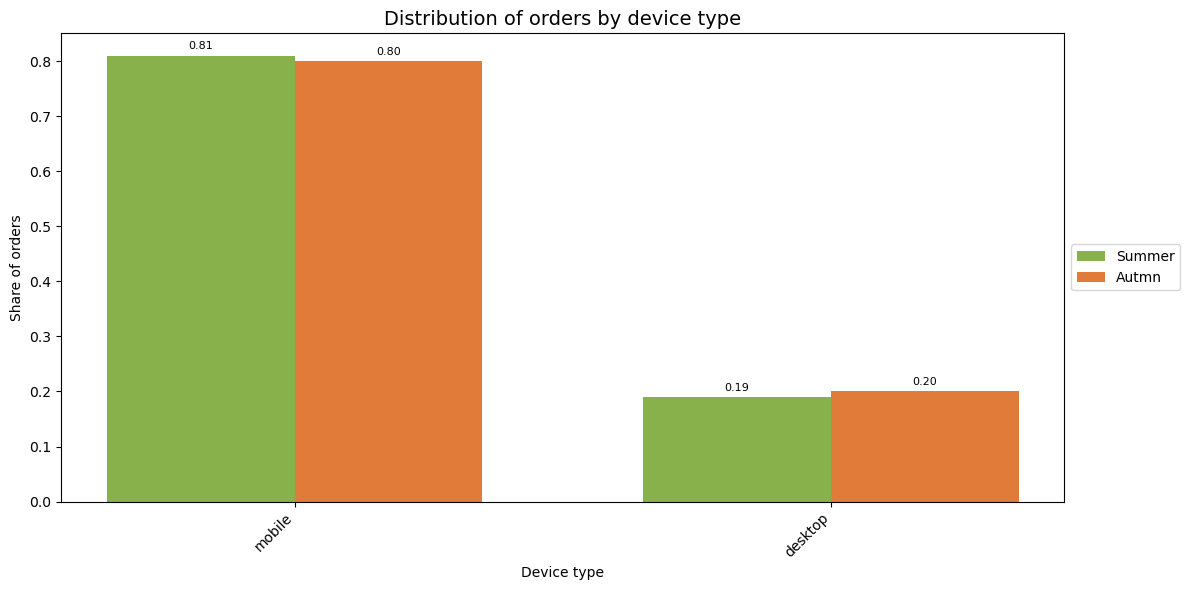

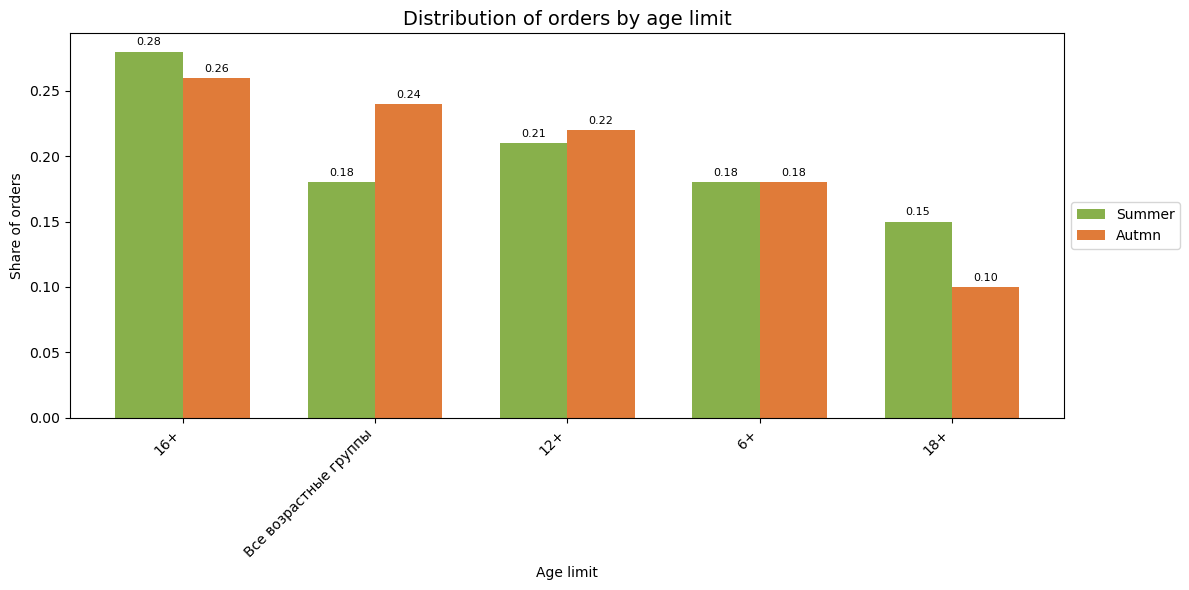

In [41]:
# General visualization function for summer/autumn comparison by shares
def plot_season_comparison(summer_dist, autumn_dist, title, xlabel):
    
    # Sort categories by fall season shares
    categories = sorted(set(summer_dist.index).union(set(autumn_dist.index)), key=lambda cat: autumn_dist.get(cat, 0), reverse=True)

    # Calculate shares for summer and autumn seasons
    summer_values = [round(summer_dist.get(cat, 0), 2) for cat in categories]
    autumn_values = [round(autumn_dist.get(cat, 0), 2) for cat in categories]

    x = range(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    # Colors for graphs
    summer_color = '#88B04B'  
    autumn_color = '#E07B39' 

    # Columns for summer and autumn schedule
    bars1 = ax.bar([i - width / 2 for i in x], summer_values, width=width, label='Summer', color=summer_color)
    bars2 = ax.bar([i + width / 2 for i in x], autumn_values, width=width, label='Autmn', color=autumn_color)

    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Share of orders")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points", 
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Plotting graphs
plot_season_comparison(summer_event_type_dist, autumn_event_type_dist, 
                       "Distribution of orders by event type", "Event type")

plot_season_comparison(summer_device_type_dist, autumn_device_type_dist, 
                       "Distribution of orders by device type", "Device type")

plot_season_comparison(summer_age_limit_dist, autumn_age_limit_dist, 
                       "Distribution of orders by age limit", "Age limit")

**Event type:**

Summer:

Concerts are the most popular type of events (42%), then there are many orders for "Other" events, which are difficult to classify (27%), theater events are also popular, but the share is smaller (20%). The popularity of Stand-up, Sports and Exhibitions events in the summer is small (from 5 to 2%). There are no orders for Christmas trees, which is logical, since such events are usually held in the winter.

Fall:

Concerts are still the most popular (37%). Theater is also gaining popularity (25%) and there is a growth in interest in sports events (11%) compared to the summer. Orders for Christmas trees are starting to appear (1%).

**Device type:**

Both in summer and fall, a large share of orders are made from mobile devices (80-81%).

**Age limit:**

Summer:

Popular events are for 16+ (28%), 12+ (21%) and 6+ (18%). There is also demand for events suitable for all age categories (18%). Events for 18+ are less popular.

Autumn:

As before, the most popular events are for 16+ (26%). There is an increase in interest in events for all age groups (24%) and a decrease in interest in events for adults.

Thus, we can say that in the fall there is an increase in interest in sports events and theatrical performances, and the share of orders for events for the whole family increases. Mobile devices remain the main way to order, regardless of the season. Christmas trees are slowly starting to gain popularity in the fall.

Now let's calculate the average revenue from one ticket (in rubles) for each type of event in summer and autumn, and also calculate the relative change in autumn cost relative to summer cost.

C:\Users\Maria\AppData\Local\Temp\ipykernel_13216\329190734.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summer_revenue = summer_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean().astype('float64')
C:\Users\Maria\AppData\Local\Temp\ipykernel_13216\329190734.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  autumn_revenue = autumn_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean().astype('float64')


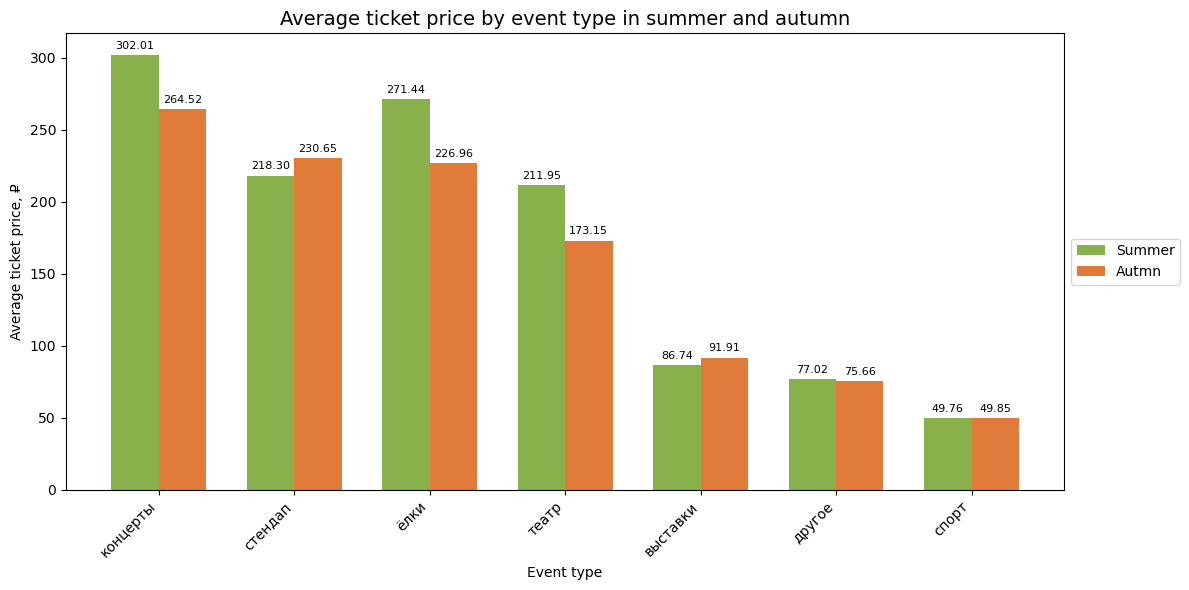

,Summer,Autmn,Change (%)
Event type,,,
концерты,302.01,264.52,-12.41
стендап,218.30,230.65,5.66
ёлки,271.44,226.96,-16.39
театр,211.95,173.15,-18.31
выставки,86.74,91.91,5.95
другое,77.02,75.66,-1.76
спорт,49.76,49.85,0.19


In [42]:
# Grouping and calculating average revenue per ticket
summer_revenue = summer_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean().astype('float64')
autumn_revenue = autumn_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean().astype('float64')

# Merging and calculating changes
revenue_comparison = pd.DataFrame({
    'Summer': summer_revenue,
    'Autmn': autumn_revenue
})
revenue_comparison['Change (%)'] = ((revenue_comparison['Autmn'] - revenue_comparison['Summer']) / 
                                       revenue_comparison['Summer'] * 100)

# Rounding and sorting
revenue_comparison = revenue_comparison.round(2).sort_values(by='Autmn', ascending=False)

# Renaming the index
revenue_comparison.index.name = 'Event type'


# Data preparation
df = revenue_comparison[['Summer', 'Autmn']].sort_values(by='Autmn', ascending=False)

categories = df.index.tolist()
summer_values = df['Summer'].round(2).tolist()
autumn_values = df['Autmn'].round(2).tolist()

x = range(len(categories))
width = 0.35

# Colors
summer_color = '#88B04B'  
autumn_color = '#E07B39'  

# Plotting a graph
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar([i - width / 2 for i in x], summer_values, width=width, label='Summer', color=summer_color)
bars2 = ax.bar([i + width / 2 for i in x], autumn_values, width=width, label='Autmn', color=autumn_color)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

ax.set_title('Average ticket price by event type in summer and autumn', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('Average ticket price, ₽')
ax.set_xlabel('Event type')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

display(revenue_comparison) 

Conclusion on the change in the distribution of orders and the average ticket price with the onset of autumn:

- **Concerts:** With the onset of autumn, the number of orders for concerts began to decrease slightly. At the same time, there is a significant decrease in the average ticket price, which may be due to the decrease in popularity of large musical events in the autumn. In the summer season, tickets were more expensive, which may reflect a greater interest in concerts in the warm season.
- **Stand-up:** In the autumn, there is a slight increase in the share of orders for stand-up, as well as an increase in the average ticket price. This may indicate the growing popularity of stand-up shows in the autumn months and higher prices for such events during this season.
- **Fir-trees:** In the fall, we see a slight increase in the number of orders. However, the average ticket price for Christmas trees decreases significantly, which may indicate a seasonal decrease in prices for events related to the upcoming New Year holidays.
- **Theater:** Theater also showed a decrease in the average ticket price in the fall. This may be related to the seasonal trend (opening of the season) of falling prices for theatrical productions, which become more accessible to viewers, which also leads to an increase in demand.
- **Exhibitions:** We see a slight decrease in the share of orders for exhibitions, with a slight increase in the average ticket price. Perhaps larger or more specialized exhibitions are held in the fall, which require higher ticket prices, while such exhibitions may attract a narrower audience.
- **Sports:** Sports events showed a virtually unchanged average ticket price and an increase in the share of orders in the fall. This may indicate stability in demand for sports events in both seasons.
- **Other:** There is a decrease in both the share of orders and the average ticket price. This may be related to a change in the composition of events falling into this category and a decrease in interest in them in the fall in general.

Our observations confirm that fall in general leads to changes in demand for different types of events, as well as to price adjustments depending on the season.

### Autumn user activity

Let's move on to an analysis of changes in user behavior in the autumn months.

In [43]:
# Group data by days
daily_data = autumn_df.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'),                 
    active_users=('user_id', 'nunique'),                 
    avg_orders_per_user=('order_id', 'count')  
).reset_index()

# Calculate the average number of orders per user
daily_data['avg_orders_per_user'] = daily_data['total_orders'] / daily_data['active_users']

# Average cost of one ticket
daily_data['avg_ticket_revenue'] = autumn_df.groupby('created_dt_msk')['one_ticket_revenue_rub'].mean().values

display(daily_data.head())

,created_dt_msk,total_orders,active_users,avg_orders_per_user,avg_ticket_revenue
0,2024-09-01,1318,559,2.357782,197.365601
1,2024-09-02,1371,571,2.401051,189.300507
2,2024-09-03,5077,774,6.559432,79.485176
3,2024-09-04,1740,677,2.570162,176.605072
4,2024-09-05,1919,730,2.628767,187.198624


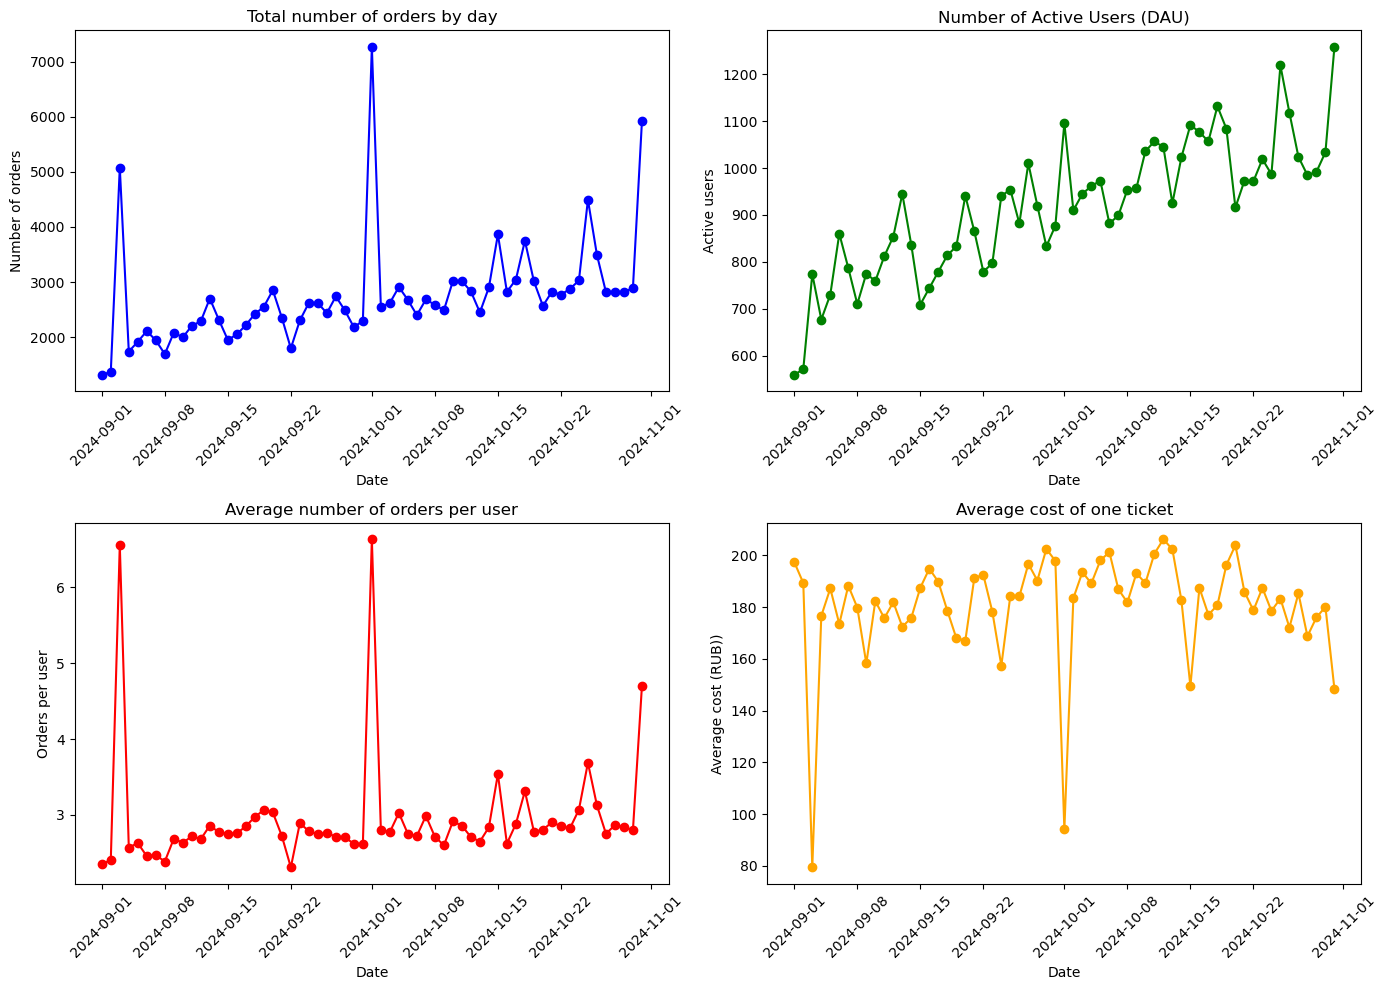

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Total Orders Chart
ax[0, 0].plot(daily_data['created_dt_msk'], daily_data['total_orders'], color='b', marker='o')
ax[0, 0].set_title("Total number of orders by day", fontsize=12)
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Number of orders')
ax[0, 0].tick_params(axis='x', rotation=45)

#DAU Chart
ax[0, 1].plot(daily_data['created_dt_msk'], daily_data['active_users'], color='g', marker='o')
ax[0, 1].set_title("Number of Active Users (DAU)", fontsize=12)
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Active users')
ax[0, 1].tick_params(axis='x', rotation=45)

# Average Orders Per User Graph
ax[1, 0].plot(daily_data['created_dt_msk'], daily_data['avg_orders_per_user'], color='r', marker='o')
ax[1, 0].set_title("Average number of orders per user", fontsize=12)
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Orders per user')
ax[1, 0].tick_params(axis='x', rotation=45)

# Average Ticket Cost Graph
ax[1, 1].plot(daily_data['created_dt_msk'], daily_data['avg_ticket_revenue'], color='orange', marker='o')
ax[1, 1].set_title("Average cost of one ticket", fontsize=12)
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Average cost (RUB))')
ax[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- From the beginning of September to the end of October, there is a fairly stable increase in the number of orders. High rates are recorded at the beginning (~ 5 000 orders) and the end of September (~ 7 500 orders), and a strong peak of orders is present at the end of October (~ 6 000 orders). In the middle and towards the end of October, there are also days with a fairly large number of orders.

- The number of active users also grows from the beginning of September to the end of October, increasing from ~ 550 users to ~ 1 300 by the end of the study period. In general, an increase in the number of orders and an increase in the number of active users indicate an increase in engagement.

- The average number of orders per user remains relatively stable, fluctuating around 2-3 orders per user per day. Particularly high values were recorded at the beginning and end of September (more than 6 orders per user, respectively), as well as at the end of October (~ 5 orders). This may be due to mass promotions or major events on these days.

- The average cost of one ticket varies significantly. In September it was higher, especially in the first 2 days of the month (for example, ~ 200 rubles on September 1), then on September 3 it dropped sharply to ~ 80 rubles. At the end of September there was also a sharp drop in the cost to 100 rubles. In October, the cost of tickets drops noticeably, especially at the end of the month (~ 150 rubles). This may indicate seasonal discounts or a change in pricing policy depending on demand or types of events.

In general, we can say that there is an inverse relationship between the number of orders (total and per user) and the average cost. The peaks of orders occurred on the days of falling costs.

In [45]:
# Add a column with the day of the week (where 0 is Monday, 1 is Tuesday, etc.)
daily_data['day_of_week'] = daily_data['created_dt_msk'].dt.dayofweek

# Change numeric values to the name of the day of the week
daily_data['weekday_name'] = daily_data['created_dt_msk'].dt.strftime('%A')

# Calculate total values by days of the week
weekly_activity = daily_data.groupby('weekday_name').agg(
    total_orders=('total_orders', 'sum'),
    active_users=('active_users', 'sum'),
    avg_orders_per_user=('avg_orders_per_user', 'mean'),
    avg_ticket_revenue=('avg_ticket_revenue', 'mean')
).reset_index()

# Let's arrange the days of the week in order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_activity['weekday_name'] = pd.Categorical(weekly_activity['weekday_name'], categories=ordered_days, ordered=True)
weekly_activity = weekly_activity.sort_values('weekday_name').reset_index(drop=True)

# Let's divide it into weekdays and weekends
weekly_activity['is_weekend'] = weekly_activity['weekday_name'].isin(['Saturday', 'Sunday'])

# Comparison of activity on weekdays and weekends
weekend_activity = weekly_activity[weekly_activity['is_weekend'] == True]
weekday_activity = weekly_activity[weekly_activity['is_weekend'] == False]

display(weekly_activity)

,weekday_name,total_orders,active_users,avg_orders_per_user,avg_ticket_revenue,is_weekend
0,Monday,21339,7644,2.771746,182.513779,False
1,Tuesday,31226,8359,3.711338,154.338684,False
2,Wednesday,22621,8254,2.739448,182.974976,False
3,Thursday,26831,8583,3.052892,178.657654,False
4,Friday,24583,8126,2.992899,182.928986,False
5,Saturday,21119,7628,2.754207,189.801010,True
6,Sunday,19183,7337,2.594753,194.700958,True


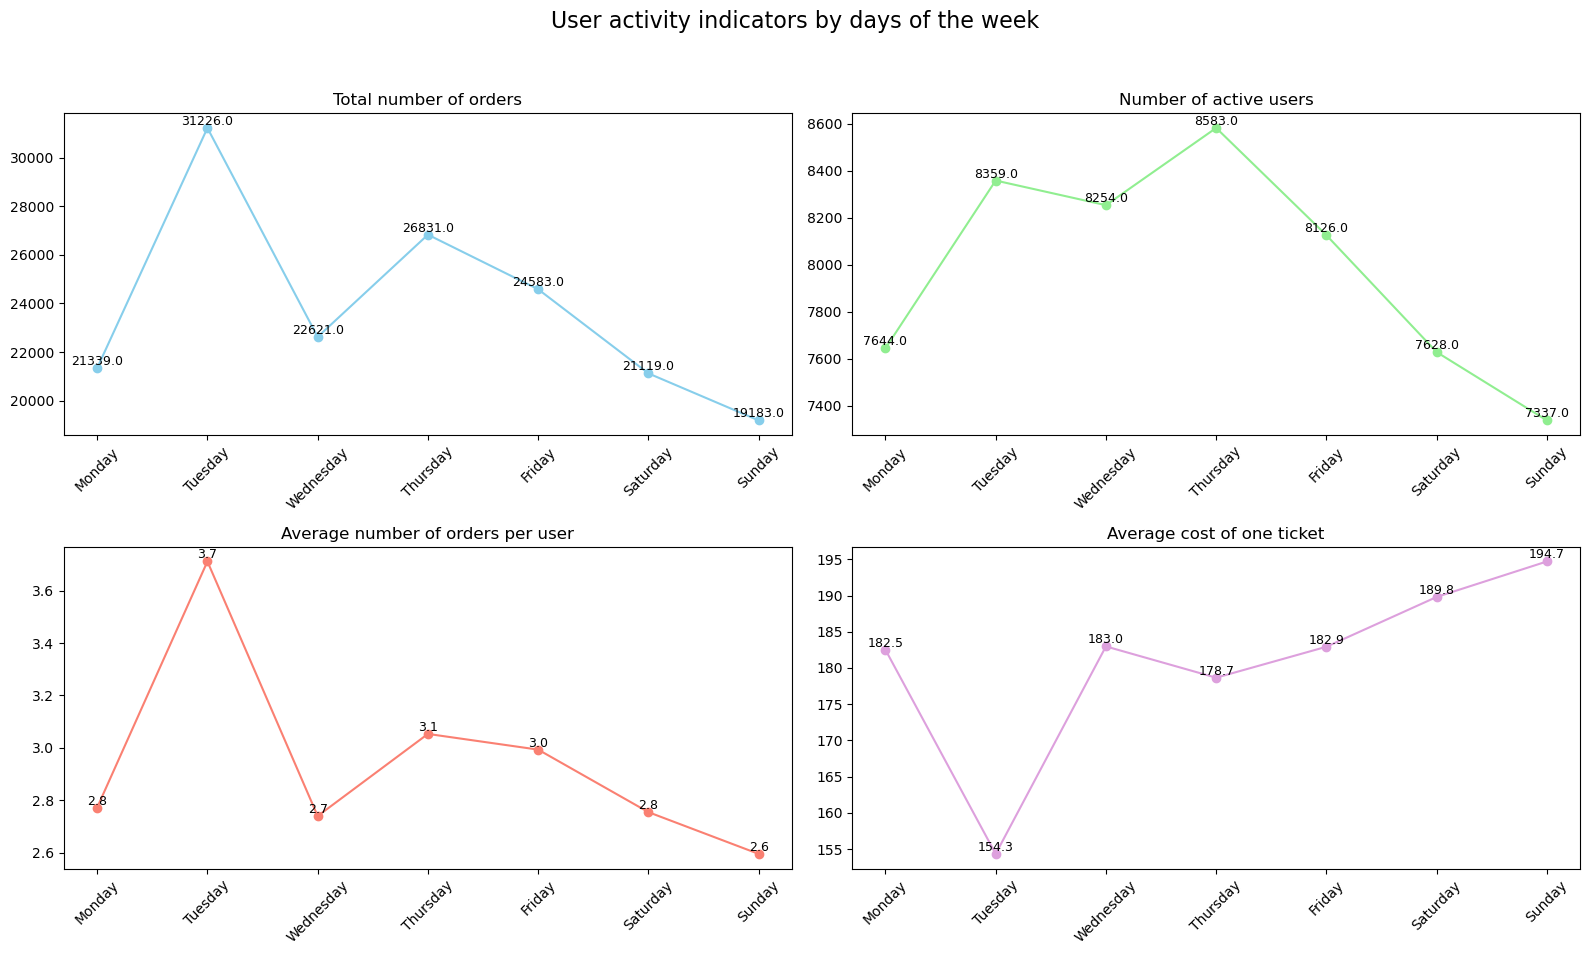

In [46]:
# Helper function for labeling values on lines
def add_line_labels(ax, x, y):
    for i, val in enumerate(y):
        ax.text(x[i], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9)

# Set the size of the overall figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('User activity indicators by days of the week', fontsize=16)

# Preparing the axles
x = weekly_activity['weekday_name']

# Graph 1: Total number of orders
y1 = weekly_activity['total_orders']
axs[0, 0].plot(x, y1, marker='o', color='skyblue')
axs[0, 0].set_title('Total number of orders')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].grid(False)
add_line_labels(axs[0, 0], x, y1)

# Graph 2: Number of active users
y2 = weekly_activity['active_users']
axs[0, 1].plot(x, y2, marker='o', color='lightgreen')
axs[0, 1].set_title('Number of active users')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].grid(False)
add_line_labels(axs[0, 1], x, y2)

# Graph 3: Average number of orders per user
y3 = weekly_activity['avg_orders_per_user']
axs[1, 0].plot(x, y3, marker='o', color='salmon')
axs[1, 0].set_title('Average number of orders per user')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].grid(False)
add_line_labels(axs[1, 0], x, y3)

# Graph 4: Average cost of one ticket
y4 = weekly_activity['avg_ticket_revenue']
axs[1, 1].plot(x, y4, marker='o', color='plum')
axs[1, 1].set_title('Average cost of one ticket')
axs[1, 1].grid(False)
axs[1, 1].tick_params(axis='x', rotation=45)
add_line_labels(axs[1, 1], x, y4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Tuesdays are the most active days. This applies to both the total number of orders and the average number of orders per user. This trend may indicate that users are more likely to make purchases and take action after the weekend, perhaps due to new information or promotions starting at the beginning of the week.
- Weekends (Saturday and Sunday) show a decrease in overall user activity. Sunday, in particular, stands out as the day with the fewest orders and active users, which may indicate that users may be relaxing and less involved in shopping on this day.
- Despite this, the average ticket price is higher on weekends.

Thus, the data clearly shows a weekly cyclicality: weekdays are characterized by higher user activity and the number of orders (especially Tuesday and Thursday), while on weekends the figures decrease, but the average ticket price increases. This indicates stable user behavior patterns depending on the day of the week.

In [47]:
# Group by weekend/weekday
weekend_vs_weekday = weekly_activity.groupby('is_weekend').agg({
    'total_orders': 'mean',
    'active_users': 'mean',
    'avg_orders_per_user': 'mean',
    'avg_ticket_revenue': 'mean'
}).reset_index()

# Replace the boolean column with clear labels
weekend_vs_weekday['day_type'] = weekend_vs_weekday['is_weekend'].map({False: 'Weekdays', True: 'Weekend'})
weekend_vs_weekday = weekend_vs_weekday.drop(columns='is_weekend')

display(weekend_vs_weekday)

,total_orders,active_users,avg_orders_per_user,avg_ticket_revenue,day_type
0,25320.0,8193.2,3.053665,176.282806,Weekdays
1,20151.0,7482.5,2.674480,192.250977,Weekend


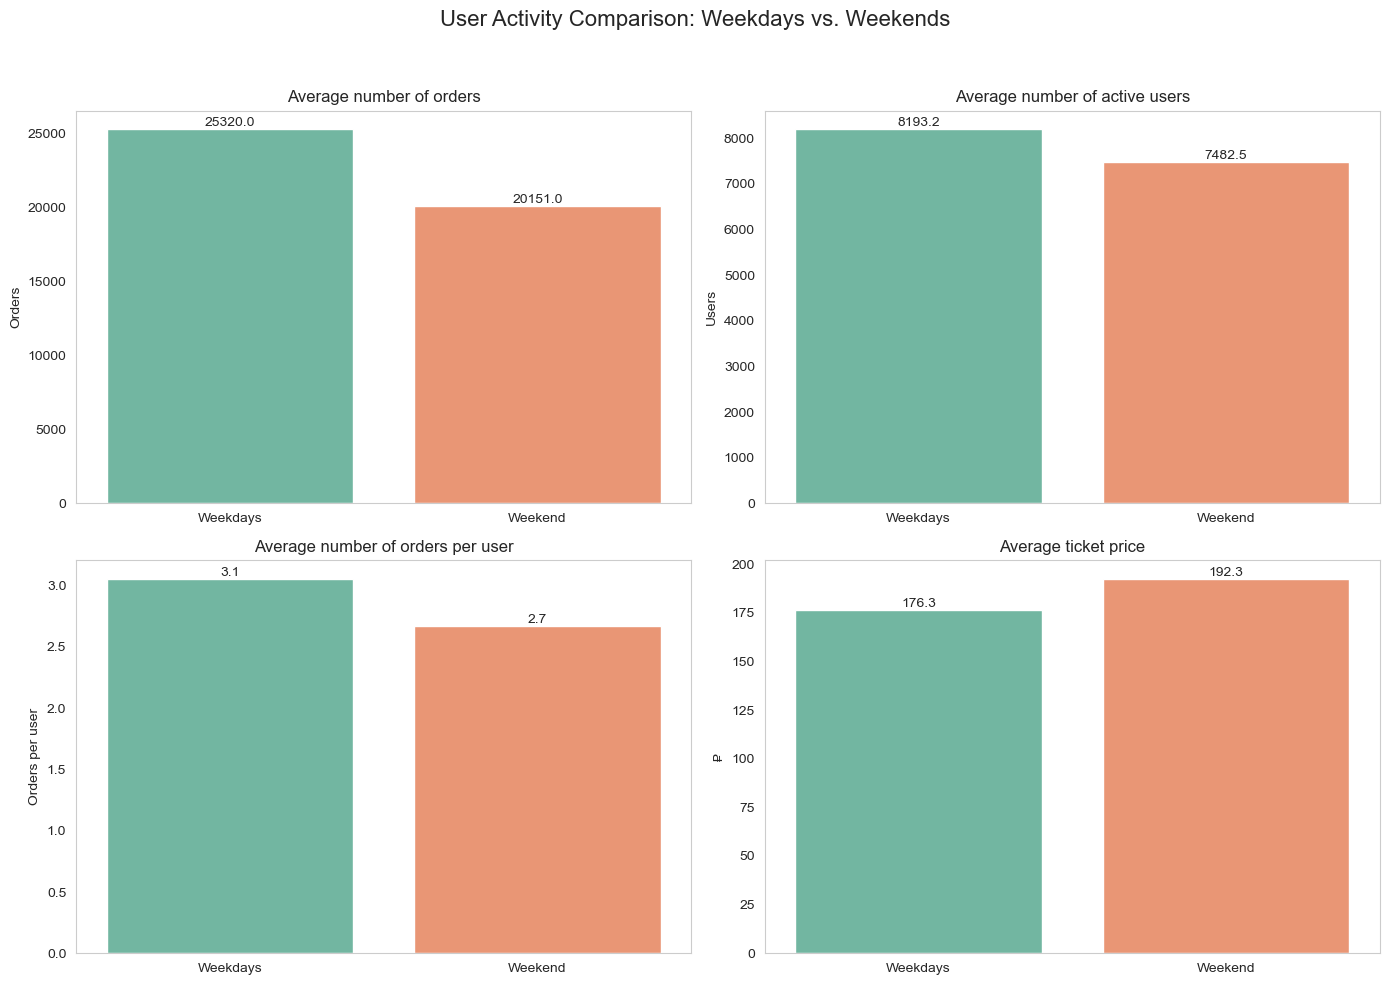

In [49]:
# Create 2 lines with 2 graphs
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('User Activity Comparison: Weekdays vs. Weekends', fontsize=16)

# Style for all charts
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", 2) 

# Helper function for adding signatures
def add_bar_labels(ax, values):
    for i, v in enumerate(values):
        ax.annotate(f'{v:.1f}', xy=(i, v), ha='center', va='bottom', fontsize=10)

# Graph 1 - Total number of orders
sns.barplot(data=weekend_vs_weekday, x='day_type', y='total_orders', hue='day_type',
            ax=axs[0, 0], palette=palette, legend=False)
axs[0, 0].set_title('Average number of orders')
axs[0, 0].set_ylabel('Orders')
axs[0, 0].set_xlabel('')
axs[0, 0].grid(False)
add_bar_labels(axs[0, 0], weekend_vs_weekday['total_orders'])

# Graph 2 - Active Users
sns.barplot(data=weekend_vs_weekday, x='day_type', y='active_users', hue='day_type',
            ax=axs[0, 1], palette=palette, legend=False)
axs[0, 1].set_title('Average number of active users')
axs[0, 1].set_ylabel('Users')
axs[0, 1].set_xlabel('')
axs[0, 1].grid(False)
add_bar_labels(axs[0, 1], weekend_vs_weekday['active_users'])

# Graph 3 - Average number of orders per user
sns.barplot(data=weekend_vs_weekday, x='day_type', y='avg_orders_per_user', hue='day_type',
            ax=axs[1, 0], palette=palette, legend=False)
axs[1, 0].set_title('Average number of orders per user')
axs[1, 0].set_ylabel('Orders per user')
axs[1, 0].set_xlabel('')
axs[1, 0].grid(False)
add_bar_labels(axs[1, 0], weekend_vs_weekday['avg_orders_per_user'])

# Graph 4 - Average ticket price
sns.barplot(data=weekend_vs_weekday, x='day_type', y='avg_ticket_revenue', hue='day_type',
            ax=axs[1, 1], palette=palette, legend=False)
axs[1, 1].set_title('Average ticket price')
axs[1, 1].set_ylabel('₽')
axs[1, 1].set_xlabel('')
axs[1, 1].grid(False)
add_bar_labels(axs[1, 1], weekend_vs_weekday['avg_ticket_revenue'])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Weekdays show higher user activity and total number of orders, which may indicate greater involvement in the shopping process during the week. At the same time, on weekends, people make more expensive purchases despite lower activity in terms of orders and users.

### Popular events and partners

Let's move on to identifying key regions and partners that make the largest contribution to revenue.

Let's start with regions and examine the shares of unique events and orders.

In [50]:
# Grouping by region: unique events and total number of orders
region_stats = (
    merged_df
    .groupby('region_name')
    .agg(
        unique_events=('event_id', 'nunique'), 
        total_orders=('order_id', 'count')      
        )
    .reset_index()
)

# Calculating shares
region_stats['event_share'] = region_stats['unique_events'] / region_stats['unique_events'].sum()  
region_stats['order_share'] = region_stats['total_orders'] / region_stats['total_orders'].sum() 

# Sort by share of unique events
region_stats_sorted = region_stats.sort_values(by='event_share', ascending=False)

region_stats_sorted.head(10)

,region_name,unique_events,total_orders,event_share,order_share
23,Каменевский регион,5903,88594,0.265638,0.311286
60,Североярская область,3778,43141,0.170012,0.151581
77,Широковская область,1224,15973,0.055081,0.056123
57,Светополянский округ,1068,7425,0.048060,0.026089
52,Речиновская область,701,6209,0.031545,0.021816
74,Травяная область,680,4941,0.030600,0.017361
11,Горицветская область,551,5146,0.024795,0.018081
61,Серебринская область,541,5580,0.024345,0.019606
78,Яблоневская область,534,6084,0.024030,0.021377
69,Тепляковская область,527,4360,0.023715,0.015319


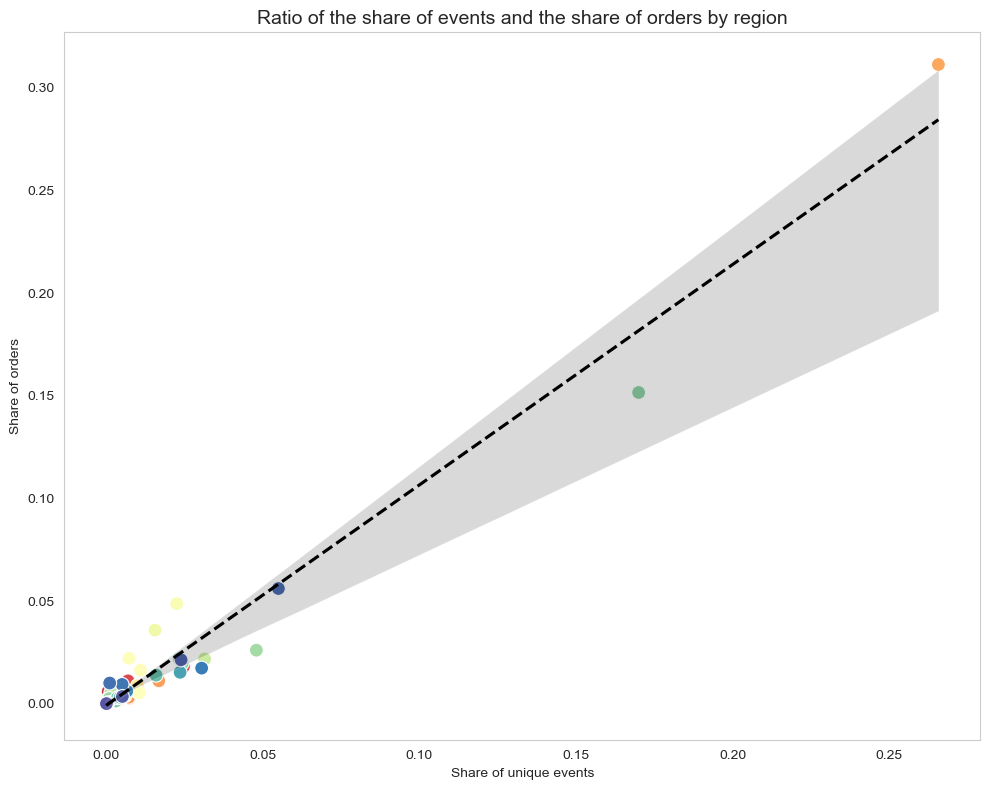

In [51]:
plt.figure(figsize=(10, 8))

# Dot plot
sns.scatterplot(
    data=region_stats,
    x='event_share',
    y='order_share',
    hue='region_name',
    palette='Spectral',
    legend=False, 
    s=100
)

# Add a trend line
sns.regplot(
    data=region_stats,
    x='event_share',
    y='order_share',
    scatter=False,
    color='black',
    line_kws={"linestyle":"dashed"}
)

plt.title('Ratio of the share of events and the share of orders by region', fontsize=14)
plt.xlabel('Share of unique events')
plt.ylabel('Share of orders')

plt.grid(False)
plt.tight_layout()
plt.show()

In general, it is clear that as the share of unique events increases, so does the share of orders (the dots are diagonal from bottom left to top right). This is logical - more offers attract more buyers.

There are regions that have many events, but relatively few orders - they are on the right, but below the trend line. This may indicate insufficient demand or weak promotion.

And vice versa, some regions receive more orders than expected by the number of events - such dots will be above the trend line. Perhaps there is high audience involvement or more popular events.

We see that most regions are concentrated in the zone of up to 5% of the share of both events and orders, but there are several regions that stand out from the general trend. Let's look at the TOP-5 of such regions by events and by orders.

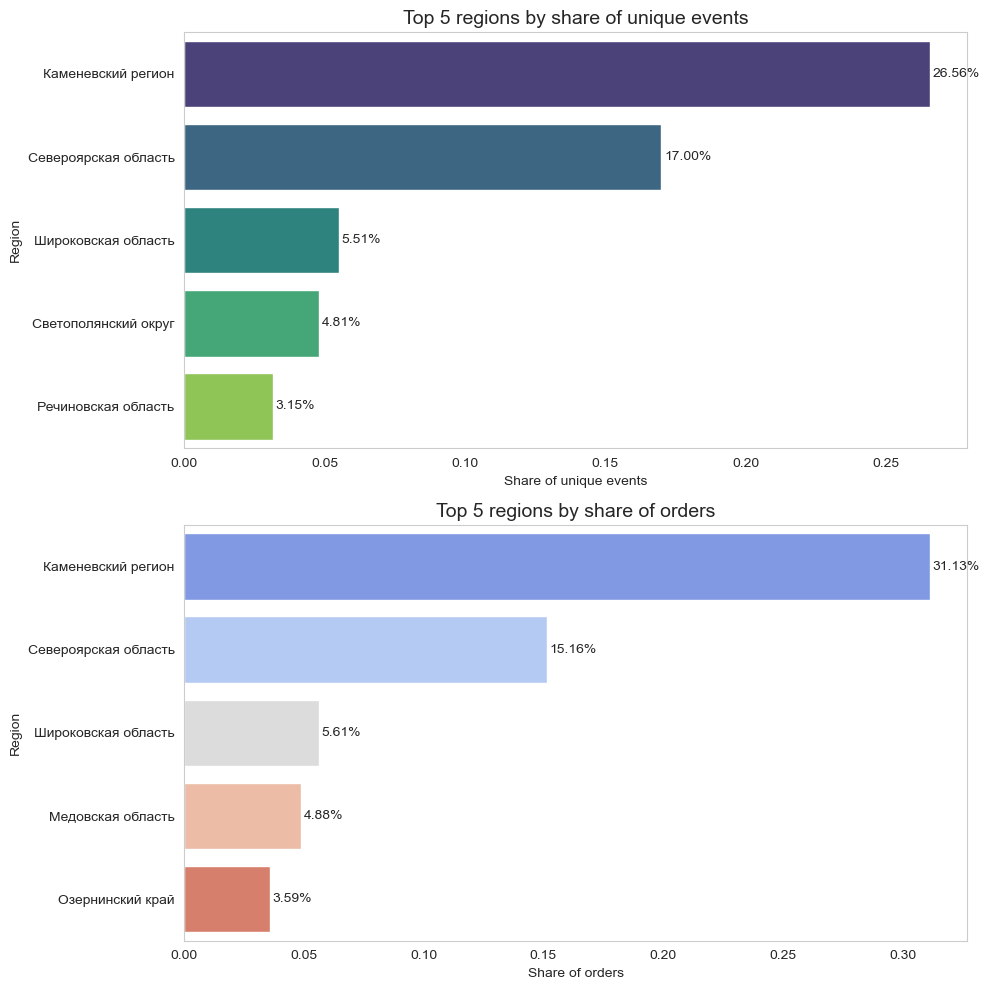

In [53]:
# We select the top 5 regions by the share of unique events and orders
top_regions_events = region_stats_sorted.head(5)
top_regions_orders = region_stats.sort_values(by='order_share', ascending=False).head(5)

# Set the size of the overall figure
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Graph 1: Top 5 regions by number of unique events
sns.barplot(
    data=top_regions_events,
    y='region_name',
    x='event_share',
    hue='region_name',
    ax=axs[0],
    palette='viridis',
    legend=False
)
axs[0].set_title('Top 5 regions by share of unique events', fontsize=14)
axs[0].set_xlabel('Share of unique events')
axs[0].set_ylabel('Region')

for i, v in enumerate(top_regions_events['event_share']):
    axs[0].text(v + 0.001, i, f'{v:.2%}', va='center')

# Graph 2: Top 5 regions by number of orders
sns.barplot(
    data=top_regions_orders,
    y='region_name',
    x='order_share',
    hue='region_name',
    ax=axs[1],
    palette='coolwarm',
    legend=False
)
axs[1].set_title('Top 5 regions by share of orders', fontsize=14)
axs[1].set_xlabel('Share of orders')
axs[1].set_ylabel('Region')

for i, v in enumerate(top_regions_orders['order_share']):
    axs[1].text(v + 0.001, i, f'{v:.2%}', va='center')

for ax in axs:
    ax.grid(False)

plt.tight_layout()
plt.show()

- Kamenevsky region (share of unique events - 26.56%, share of orders - 31.13%) occupies a leading position, with a slight bias towards supply, but remains within the balanced market.
- Severoyarsk region (share of unique events - 17.00%, share of orders - 15.16%) and Shirokovskaya region (share of unique events - 5.51%, share of orders - 5.61%) also show a moderate balance between supply and demand, which creates a healthy market situation.
- In Medovskaya region (share of unique events - 2.26%, share of orders - 4.88%) and Ozerny territory (share of unique events - 1.57%, share of orders - 3.59%) there is a clear shortage of supply, since the share of orders is significantly higher than the share of unique events. This indicates a growing demand that is not fully satisfied by the existing supply. There is potential for expanding the offerings, which can lead to improved customer satisfaction and market growth in these regions.
- Svetopolyansky District (share of unique events - 4.81%, share of orders - 2.61%) and Rechinovskaya Oblast (share of unique events - 3.15%, share of orders - 2.18%) show an oversupply, which is confirmed by their high share of unique events with a significantly lower share of orders. This may mean that the market is oversaturated with offers, which can reduce sales efficiency.

Thus, Kamenevsky Region, Severoyarsk and Shirokovskaya Oblasts are zones of balanced supply and demand. Medovskaya Oblast and Ozerny Krai are zones of potential event deficit, where demand exceeds supply. At the same time, Svetopolyansky District and Rechinovskaya Oblast are zones with an oversupply, which is not accompanied by equal demand

Now let's move on to the analysis of ticket partners.

In [54]:
# Grouping by partners
partner_stats = (
    merged_df
    .groupby('service_name')
    .agg(
        unique_events=('event_id', 'nunique'), 
        total_orders=('order_id', 'count'),
        total_revenue=('revenue_rub', 'sum')
    )
    .reset_index()
)

# Calculating shares
partner_stats['event_share'] = partner_stats['unique_events'] / partner_stats['unique_events'].sum()
partner_stats['order_share'] = partner_stats['total_orders'] / partner_stats['total_orders'].sum()
partner_stats['revenue_share'] = partner_stats['total_revenue'] / partner_stats['total_revenue'].sum()

# Combined sorting by revenue and number of orders
partner_stats_sorted = partner_stats.sort_values(by=['revenue_share', 'order_share'], ascending=[False, False])

partner_stats_sorted.head(10)

,service_name,unique_events,total_orders,total_revenue,event_share,order_share,revenue_share
3,Билеты без проблем,4196,62206,23625378.0,0.173088,0.218569,0.163999
24,Мой билет,1288,34239,21675440.0,0.053131,0.120303,0.150463
25,Облачко,2332,26336,18446294.0,0.096197,0.092535,0.128048
21,Лови билет!,4845,40478,16134624.0,0.199860,0.142225,0.112001
8,Весь в билетах,854,16021,15663259.0,0.035228,0.056292,0.108729
5,Билеты в руки,3510,39968,12787462.0,0.144790,0.140433,0.088766
19,Край билетов,251,6070,6331290.0,0.010354,0.021328,0.043950
26,Прачечная,1024,10179,4658010.0,0.042241,0.035765,0.032334
13,Дом культуры,267,4189,3886844.0,0.011014,0.014719,0.026981
35,Яблоко,713,4925,3702272.0,0.029412,0.017305,0.025700


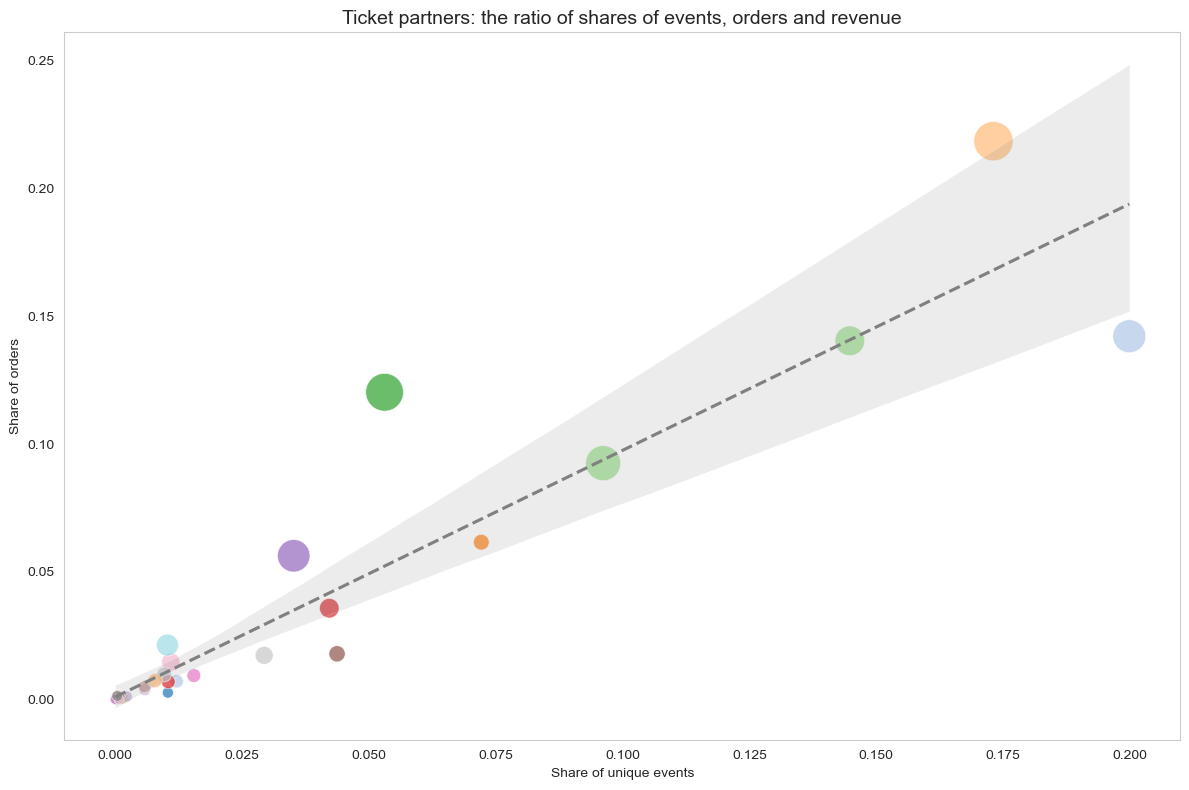

In [55]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=partner_stats,
    x='event_share',
    y='order_share',
    size='revenue_share',
    hue='service_name',
    sizes=(50, 800), 
    alpha=0.7,
    palette='tab20', 
    legend=False 
)

# Trend line
sns.regplot(
    data=partner_stats,
    x='event_share',
    y='order_share',
    scatter=False,
    color='gray',
    line_kws={"linestyle": "dashed"}
)

plt.title('Ticket partners: the ratio of shares of events, orders and revenue', fontsize=14)
plt.xlabel('Share of unique events')
plt.ylabel('Share of orders')

plt.grid(False)
plt.tight_layout()
plt.show()


The visualization shows the ratio between the shares of unique events and orders, additionally taking into account revenue as the size of the dot.

The first thing that catches the eye is that the market is unevenly distributed.

- Some partners are characterized by a proportional relationship between reach (events) and demand (orders). These partners also have a significant share of revenue. (The dots are located closer to the diagonal)
- There is a group of partners (located to the right and below the diagonal trend), for whom the share of events significantly exceeds the share of orders and / or revenue.
- Individual dots are noticeably large, but with low values along the reach and orders axis. These are partners with high average revenue, who work with a limited number of events, but generate significant income. Perhaps these are niche or premium platforms.
- The lower left sector is occupied by many small dots, corresponding to partners with insignificant shares in all three metrics. Their contribution to the overall structure of orders and income is minimal.

Visualize the TOP-5 partners for each parameter.

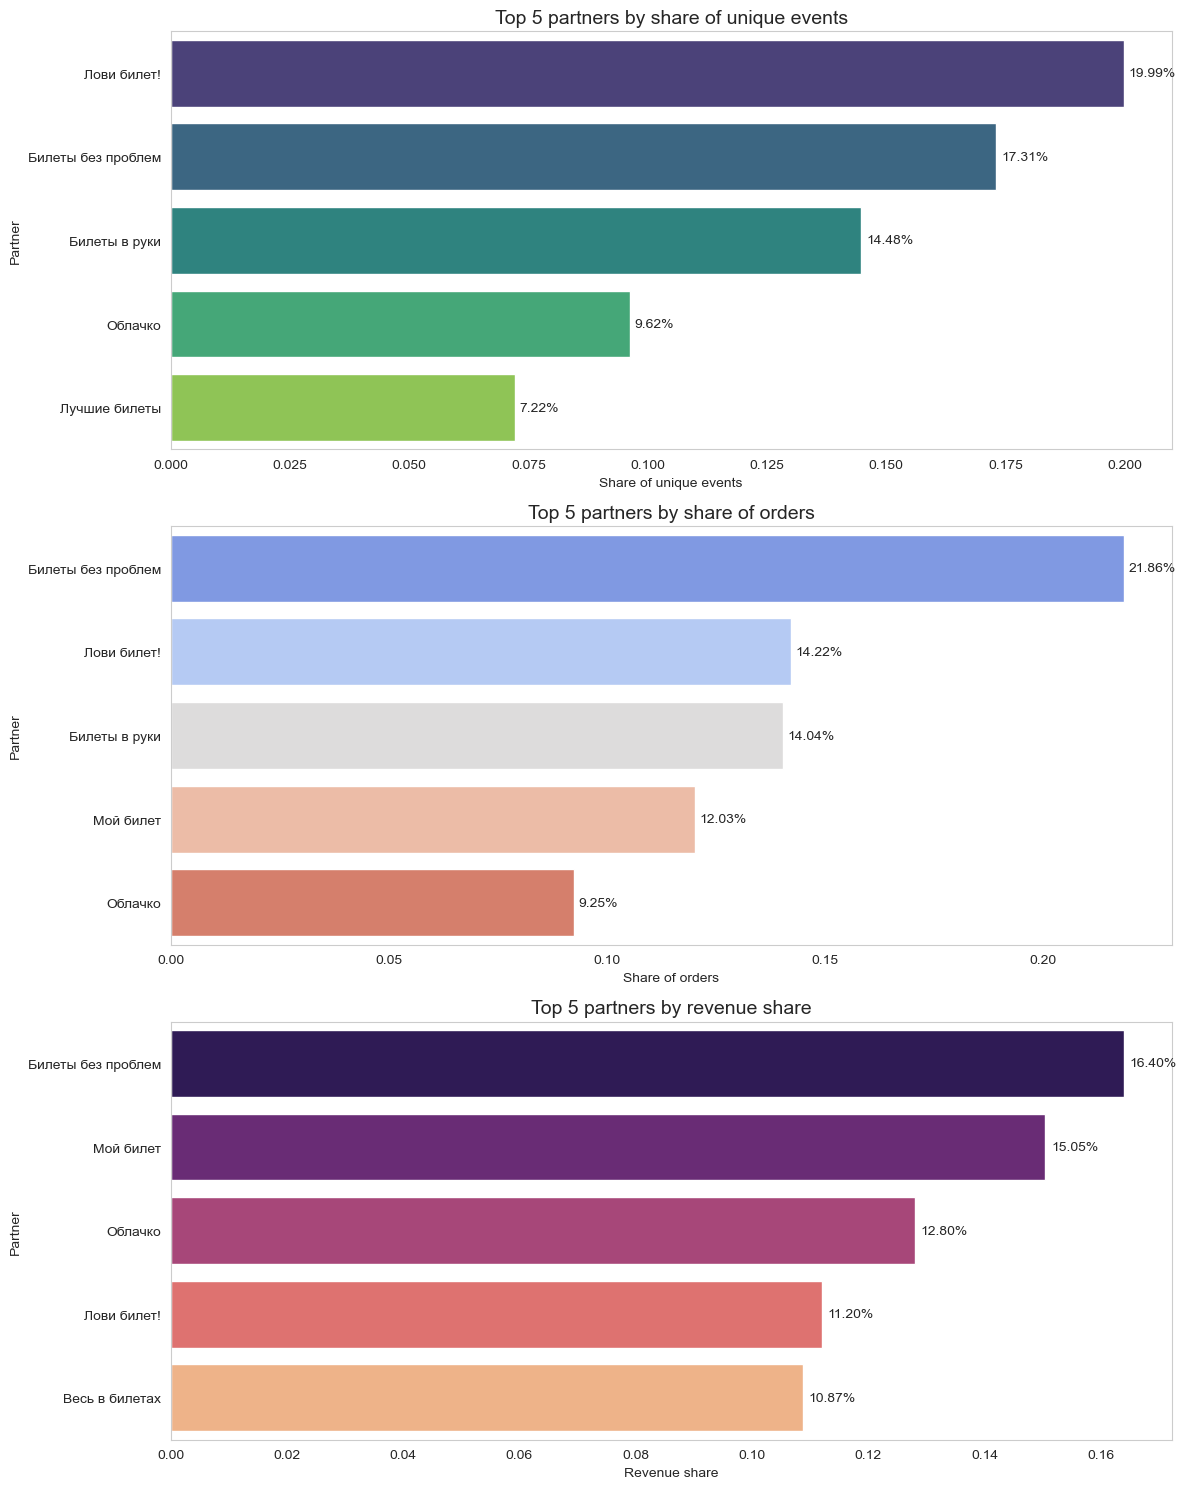

In [57]:
# Select the top 5 partners for each metric
top_event_share = partner_stats.sort_values(by='event_share', ascending=False).head(5)
top_order_share = partner_stats.sort_values(by='order_share', ascending=False).head(5)
top_revenue_share = partner_stats.sort_values(by='revenue_share', ascending=False).head(5)

# Create a figure with three subgraphs
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Graph 1: Top 5 by share of unique events
sns.barplot(
    data=top_event_share,
    y='service_name',
    x='event_share',
    hue='service_name',
    ax=axs[0],
    palette='viridis',
    legend=False
)
axs[0].set_title('Top 5 partners by share of unique events', fontsize=14)
axs[0].set_xlabel('Share of unique events')
axs[0].set_ylabel('Partner')
for i, v in enumerate(top_event_share['event_share']):
    axs[0].text(v + 0.001, i, f'{v:.2%}', va='center')

# Graph 2: Top 5 by share of orders
sns.barplot(
    data=top_order_share,
    y='service_name',
    x='order_share',
    hue='service_name',
    ax=axs[1],
    palette='coolwarm',
    legend=False
)
axs[1].set_title('Top 5 partners by share of orders', fontsize=14)
axs[1].set_xlabel('Share of orders')
axs[1].set_ylabel('Partner')
for i, v in enumerate(top_order_share['order_share']):
    axs[1].text(v + 0.001, i, f'{v:.2%}', va='center')

# Chart 3: Top 5 by revenue share
sns.barplot(
    data=top_revenue_share,
    y='service_name',
    x='revenue_share',
    hue='service_name',
    ax=axs[2],
    palette='magma',
    legend=False
)
axs[2].set_title('Top 5 partners by revenue share', fontsize=14)
axs[2].set_xlabel('Revenue share')
axs[2].set_ylabel('Partner')
for i, v in enumerate(top_revenue_share['revenue_share']):
    axs[2].text(v + 0.001, i, f'{v:.2%}', va='center')

for ax in axs:
    ax.grid(False)

plt.tight_layout()
plt.show()

The top 5 partners show us the following:

- **Tickets without problems**

This partner consistently occupies leading positions in all key indicators. A high share of orders (21.86%) and revenue (16.4%) indicates high demand and a successful commercial model. However, its share of unique events (17.31) is not the largest (2nd place), which may indicate some concentration within the offers, but this does not prevent it from being a leader in revenue and orders.

- **Catch a ticket!**

A leader in the offer of events (19.99%), but the share of orders (14.22%) and revenue (11.20%) is noticeably lower. This may mean that despite a large number of offers, the conversion to orders is not so high. Perhaps it is worth strengthening marketing offers or conditions for clients.

- **Tickets in Hand**

A partner with a fairly balanced supply (14.48%) and demand (14.04%), but its revenue is not that high (not in the top 5 by revenue), which may be due to pricing policy or order volume. In general, this partner demonstrates stability.

- **Oblachko**

Although "Oblachko" does not stand out in the number of events (9.62%) and orders (9.25%), it has a very good revenue share (12.81%). This may mean that its offers are highly valued by customers, despite a more limited event base.

- **Best Tickets**

This partner has the lowest share of unique events among the top 5 (7.22%), which may indicate its less activity in the market, but it still makes it into the top 5 in terms of supply.

- **My ticket**

Despite the relatively modest number of unique events (not in the top 5), "My ticket" ranks second in revenue (15.05%) and is in the top 5 in orders. This may indicate high ticket prices, a large volume of orders (12.03%), including for one event, or strong specialization. The partner effectively monetizes a limited supply - this is an example of a high-quality focus on demand.

- **All in tickets**

The partner has few events and orders (outside the top 5), but a high share of revenue (10.87%). This may indicate expensive events, a premium segment, or high ticket prices. Despite its small scale, the service effectively makes money on its audience.

In general, the analysis of the distribution of activity by regions and partners shows that both the regional distribution and the partner structure show a high degree of unevenness:

- In some regions, there is a supply deficit, while in others there is an overabundance, which indicates local imbalances in supply and demand. Against the background of the regional breakdown, the **Kamenevsky region** stands out in particular - it demonstrates confident leadership in two key indicators at once: the share of unique events (26.56%) and the share of orders (31.13%). This indicates a balanced and active market, where high supply successfully finds a response from the audience.
- Among partners, there is a strong concentration of activity among a limited circle of players, while some of them remain inconspicuous and ineffective. Against this background, **Tickets without problems** stands out in particular, being the undisputed leader in all key indicators: the number of events, orders and revenue.

## Statistical analysis of data

We will separately test two hypotheses that suggest greater activity of mobile device users in the autumn period:
- The average number of orders per mobile app user is higher compared to users of stationary devices.
- The average time between orders for mobile app users is higher compared to users of stationary devices.

Let's get started with the preparatory steps for conducting the tests.

First, let's check if users overlap between groups.

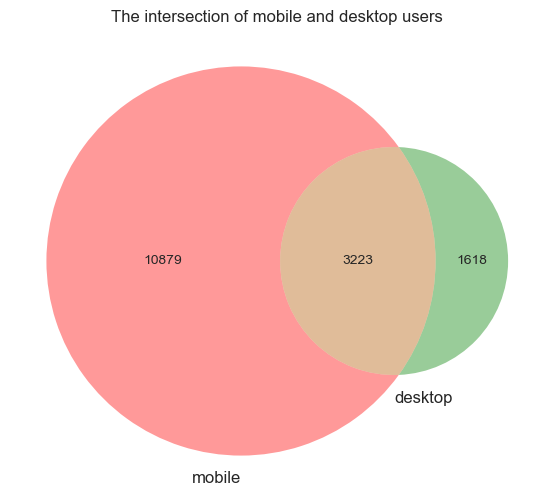

In [58]:
# Filter data by devices
mobile_users = autumn_df[autumn_df['device_type_canonical'] == 'mobile']
desktop_users = autumn_df[autumn_df['device_type_canonical'] == 'desktop']

# Define unique user_ids as sets
mobile_users_set = set(mobile_users['user_id'].unique())
desktop_users_set = set(desktop_users['user_id'].unique())

# Building a Venn diagram
plt.figure(figsize=(8, 6))
venn2([mobile_users_set, desktop_users_set], set_labels=('mobile', 'desktop'))
plt.title("The intersection of mobile and desktop users")
plt.show()

We remove from the analysis users who use both devices in order to conduct an independent and more rigorous analysis.

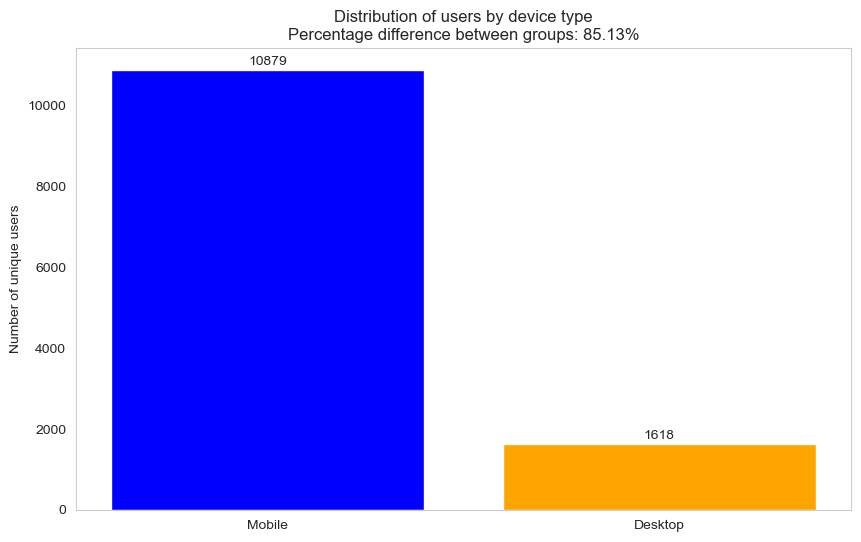

In [59]:
# Get user_id that are found in both groups
common_users = mobile_users['user_id'].isin(desktop_users['user_id'])
common_user_ids = set(mobile_users[common_users]['user_id'])

# Filter mobile and desktop groups, excluding overlapping users
mobile_unique = mobile_users[~mobile_users['user_id'].isin(common_user_ids)]
desktop_unique = desktop_users[~desktop_users['user_id'].isin(common_user_ids)]

# Let's calculate new group sizes
len_mobile_unique = mobile_unique['user_id'].nunique()
len_desktop_unique = desktop_unique['user_id'].nunique()

# Calculate the percentage difference
percent_diff = 100 * abs(len_mobile_unique - len_desktop_unique) / len_mobile_unique

# Visualizing the distribution of users by devices
device_counts = [len_mobile_unique, len_desktop_unique]
device_labels = ['Mobile', 'Desktop']

# Let's build a bar chart for visualizationи
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(device_labels, device_counts, color=['blue', 'orange'])

# Add captions above the columns
for i, count in enumerate(device_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

# Add a header with the percentage difference
ax.set_title(f'Distribution of users by device type\n'
             f'Percentage difference between groups: {percent_diff:.2f}%', fontsize=12)

ax.set_ylabel('Number of unique users')
ax.grid(False)

plt.show()

This is a significant difference in group size, and we will take this into account when selecting and interpreting the results of statistical tests.

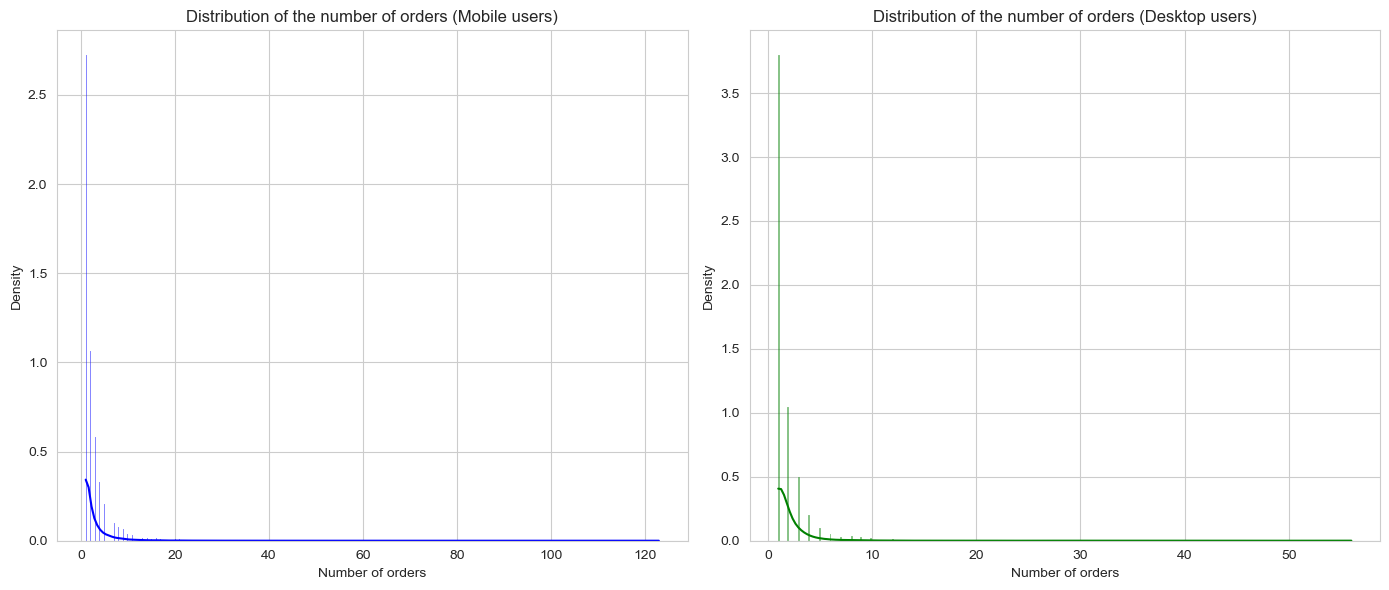

In [60]:
# Let's calculate the number of orders for each user
mobile_user_order_counts = mobile_unique.groupby('user_id')['order_id'].nunique()
desktop_user_order_counts = desktop_unique.groupby('user_id')['order_id'].nunique()

plt.figure(figsize=(14, 6))

# Histogram for mobile users
plt.subplot(1, 2, 1)
sns.histplot(mobile_user_order_counts, kde=True, color='blue', stat="density")
plt.title('Distribution of the number of orders (Mobile users)')
plt.xlabel('Number of orders')

# Histogram for desktop users
plt.subplot(1, 2, 2)
sns.histplot(desktop_user_order_counts, kde=True, color='green', stat="density")
plt.title('Distribution of the number of orders (Desktop users)')
plt.xlabel('Number of orders')

plt.tight_layout()
plt.show()

In [61]:
# Statistics for mobile and desktop users
mobile_user_order_counts_stats = mobile_user_order_counts.describe()
desktop_user_order_counts_stats = desktop_user_order_counts.describe()

display(mobile_user_order_counts_stats) 
display(desktop_user_order_counts_stats)

count    10879.000000
mean         2.855777
std          4.104409
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

count    1618.000000
mean        1.965389
std         3.057485
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_id, dtype: float64

It is obvious that mobile users have a higher average number of orders (2.85) than desktop users (1.96). The standard deviation is also higher for mobile users, which may indicate greater variability in their behavior.

Since the data contains outliers, it is better to use the non-parametric Mann-Whitney U test for statistical testing, which is not sensitive to them.

Let's move on to testing the **first hypothesis**: The average number of orders per user of the mobile application is higher compared to users of stationary devices.

- **Null hypothesis (H0)**: The average number of orders per user of the mobile application is not higher than the average number of orders per user of stationary devices. (That is, there is no difference between the groups).
- **Alternative hypothesis (H1)**: The average number of orders per user of the mobile application is higher compared to users of stationary devices.

In [62]:
# Conducting the Mann-Whitney test
stat, p_value = mannwhitneyu(mobile_user_order_counts, desktop_user_order_counts, alternative='greater')

# Display the test results
display("Mann-Whitney test result:")
display(f"p-value: {p_value:}")

if p_value < 0.05:
    print("The difference is statistically significant. The average number of orders per user of a mobile app is higher than on desktop devices.")
else:
    print("The difference is not statistically significant. The average number of orders per user of the mobile app is not greater than on desktop devices.")

'Mann-Whitney test result:'

'p-value: 4.824937564121644e-40'

The difference is statistically significant. The average number of orders per user of a mobile app is higher than on desktop devices.


Begin preparing data for the second test.

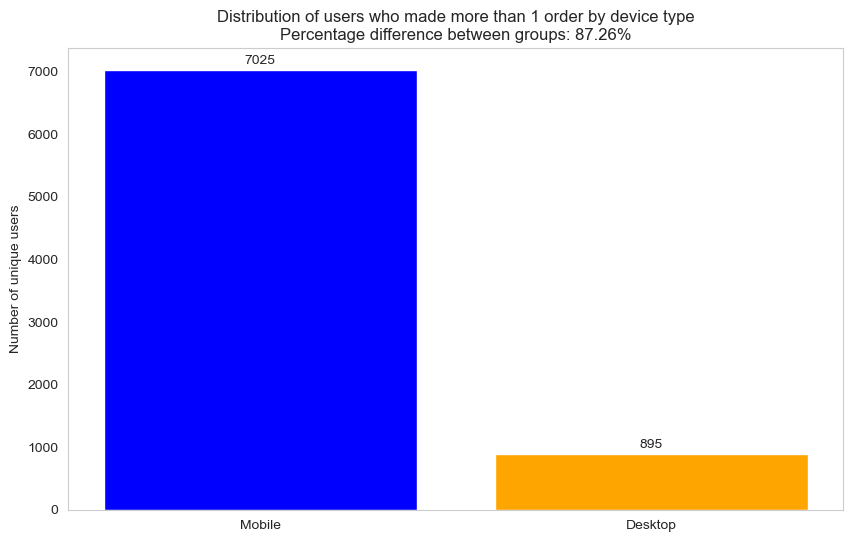

In [63]:
# Filter data for users who have more than one order, for mobile and desktop users
mobile_filtered = mobile_unique.dropna(subset=['days_since_prev'])
desktop_filtered = desktop_unique.dropna(subset=['days_since_prev'])

# Let's check the sample sizes
mobile_filtered_size = mobile_filtered['user_id'].nunique()
desktop_filtered_size = desktop_filtered['user_id'].nunique()

# Calculate the percentage difference
percent_diff = 100 * abs(mobile_filtered_size - desktop_filtered_size) / mobile_filtered_size

# Visualizing the distribution of users by devices
device_counts = [mobile_filtered_size, desktop_filtered_size]
device_labels = ['Mobile', 'Desktop']

# Let's build a bar chart for visualization
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(device_labels, device_counts, color=['blue', 'orange'])

for i, count in enumerate(device_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

# Add a header with the percentage difference
ax.set_title(f'Distribution of users who made more than 1 order by device type\n'
             f'Percentage difference between groups: {percent_diff:.2f}%', fontsize=12)

ax.set_ylabel('Number of unique users')
ax.grid(False)

plt.show()

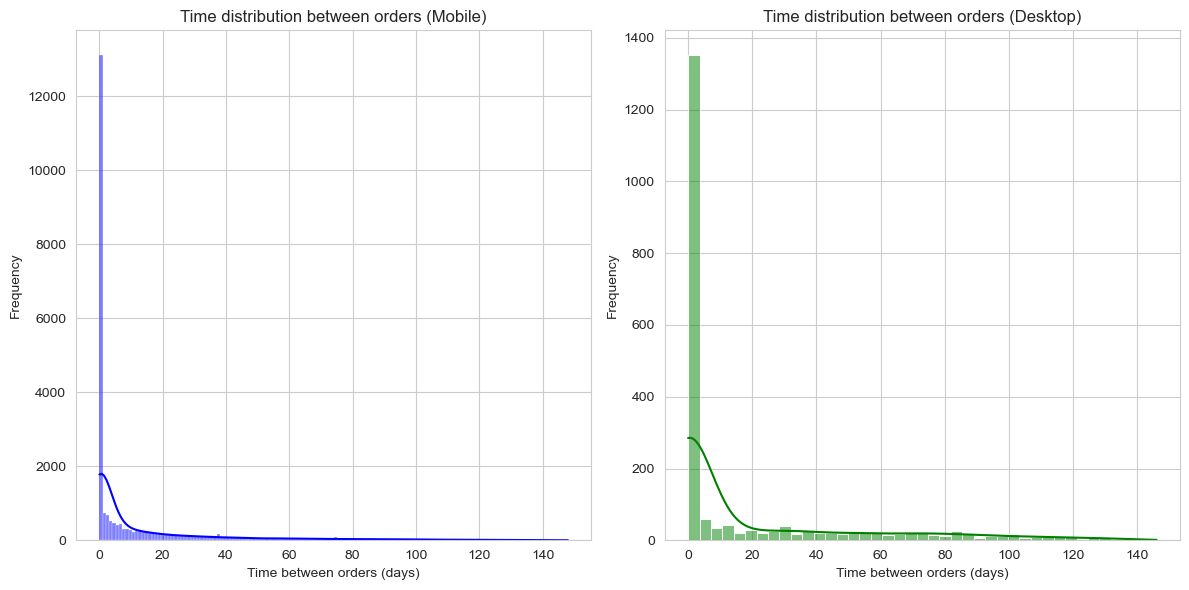

In [64]:
# Let's build histograms for the time between orders (days_since_prev) for mobile and desktop users
plt.figure(figsize=(12, 6))

# Histogram for mobile users
plt.subplot(1, 2, 1)
sns.histplot(mobile_filtered['days_since_prev'], kde=True, color='blue')
plt.title('Time distribution between orders (Mobile)')
plt.xlabel('Time between orders (days)')
plt.ylabel('Frequency')

# Histogram for desktop users
plt.subplot(1, 2, 2)
sns.histplot(desktop_filtered['days_since_prev'], kde=True, color='green')
plt.title('Time distribution between orders (Desktop)')
plt.xlabel('Time between orders (days)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [65]:
# Statistics for mobile users
mobile_filtered_stats = mobile_filtered['days_since_prev'].describe()

# Statistics for desktop users
desktop_filtered_stats = desktop_filtered['days_since_prev'].describe()

display(mobile_filtered_stats) 
display(desktop_filtered_stats)

count    24461.000000
mean        13.735661
std         25.652914
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64

count    2071.000000
mean       18.133751
std        32.592411
min         0.000000
25%         0.000000
50%         0.000000
75%        23.000000
max       146.000000
Name: days_since_prev, dtype: float64

We obtained data on the time between orders for mobile and desktop users. Based on the statistics, it is clear that for both groups, half of all orders are made either on the same day or - every other day, the remaining data also confirms that 75% of mobile repeat orders are limited to 15 days, and desktop - 23 days.

- Trends in statistical indicators indicate that mobile users are more likely to place a repeat order after a shorter period of time than desktop users.

It is important to clarify that we have zero values in the data on the time between orders (0 days). These data correspond to users who made their subsequent orders within one day.

Thus, to test the hypothesis that the average time between orders for mobile users is longer than for desktop users, we use the non-parametric Mann-Whitney test, which is suitable for data with outliers, as in our case.

Let's move on to testing the **second hypothesis**: The average time between orders for mobile app users is higher than for desktop users.
- **Null hypothesis (H0)**: The average time between orders for mobile users is not higher than for desktop users.
- **Alternative hypothesis (H1)**: The average time between orders for mobile users is higher than for desktop users.

In [66]:
# Conducting the Mann-Whitney test
mannwhitney_result_time = mannwhitneyu(mobile_filtered['days_since_prev'], desktop_filtered['days_since_prev'], alternative='greater')

# Display the test results
print("Mann-Whitney test result:")
print(f"p-value: {mannwhitney_result_time.pvalue:}")

if mannwhitney_result_time.pvalue < 0.05:
    print("The difference is statistically significant. The average (median) time between orders is longer for mobile users than for desktop devices..")
else:
    print("The difference is not statistically significant. The average (median) time between orders is no longer for mobile users than for desktop devices.")

Mann-Whitney test result:
p-value: 2.8642526667436585e-07
The difference is statistically significant. The average (median) time between orders is longer for mobile users than for desktop devices..


It is important to understand that the Mann-Whitney test compares distributions as a whole, specifically medians, rather than means. In our case, this leads to potential interpretation bias, as:

- Mobile mean = 13.74 days (median = 0)
- Desktop mean = 18.13 days (median = 1)

Despite the desktop median advantage, the average number of days between orders is higher.

Still, I would also like to test the hypothesis regarding the mean arithmetic time between orders.

- **Null hypothesis (H0)**: The mean arithmetic time between orders for mobile users is not higher than for desktop users.
- **Alternative hypothesis (H1)**: The mean arithmetic time between orders for mobile users is higher than for desktop users.

Since the data:
- does not follow a normal distribution,
- contains a large number of zeros (i.e. frequent orders on the same day),
- has different sample sizes,

then bootstrap allows you to correctly estimate the difference in the mean arithmetic between the groups.

In [67]:
def bootstrap_mean_diff_pure_python(data1, data2, iterations=10000):
    boot_diffs = []
    for _ in range(iterations):
        sample1 = random.choices(data1, k=len(data1))
        sample2 = random.choices(data2, k=len(data2))
        diff = sum(sample1)/len(sample1) - sum(sample2)/len(sample2)
        boot_diffs.append(diff)
    lower = sorted(boot_diffs)[int(0.025 * iterations)]
    upper = sorted(boot_diffs)[int(0.975 * iterations)]
    return (lower, upper), sum(boot_diffs)/len(boot_diffs)


mobile_days = mobile_filtered['days_since_prev'].tolist()
desktop_days = desktop_filtered['days_since_prev'].tolist()

ci, mean_diff = bootstrap_mean_diff_pure_python(mobile_days, desktop_days)
print("Bootstrap result:")
print(f"Average Difference (Mobile - Desktop): {mean_diff:.2f}")
print(f"95% confidence interval: {ci}")

Bootstrap result:
Average Difference (Mobile - Desktop): -4.39
95% confidence interval: (-5.827263971535331, -2.964556178874675)


Difference in means = -4.4. This means that on average, mobile app users make repeat orders 4.4 days earlier than desktop users.

The interval in which the true difference between the average time between orders of the two groups is 95% likely to be (-5.85 - -2.99). Since the entire interval is below zero and our value -4.40 is included in this interval, this means that

Even though Mann-Whitney showed the opposite result (due to its focus on ranks/median), the bootstrap says:

The average time between orders for mobile users is shorter than for desktop users, and this difference is statistically significant. (The null hypothesis "the average time between orders in the groups does not differ" is rejected). Mobile users make orders more often than desktop users.

### Intermediate output

Both hypotheses were statistically significantly confirmed, which allows us to draw important behavioral conclusions about users of different platforms. Mobile app users are more active than desktop users:

Firstly, they make more orders on average, which may indicate greater involvement or convenience of using a mobile app in everyday situations.

Secondly, their intervals between orders are significantly shorter, which means more frequent interaction with the service. This may be a consequence of a better user experience.

## General conclusion and recommendations

### Data description and preprocessing stage

Three datasets were used for the analysis: with information on ticket purchases (`orders_df`), with information on events, including cities and venues (`events_df`) and with information on the tenge to ruble exchange rate (`tenge_df`).

The data was combined, cleared of gaps and duplicates in ticket bookings (~2% of rows were removed), converted to a single currency (rubles), and supplemented with new features - order month, season and revenue per ticket. Outliers in revenue and total order cost (negative values and values > 99th percentile) were also eliminated and memory optimization was performed by reducing the data bit depth and generally changing the data type for some columns.

As a result, the final dataframe with 284,606 rows was obtained, ready for analyzing user behavior and revenue.

### Results of the analysis of the distribution of orders by segments and their seasonal changes

1. Changes in seasonal demand

A significant increase in the number of orders is observed in the fall:
- June–August: an average of 39 233 orders per month
- September–October: growth to 83 449 orders per month (+113%)

This trend may be associated with the end of the holiday season, the return of the audience to the cities and the beginning of a new cultural season.

2. Popular types of events
- Summer: concerts (42%) and theater (20%) dominate.
- Autumn: concerts remain the leaders (37%), but interest in theater (25%) and sports (11%) is growing. Orders for New Year's trees are starting to appear.

The decrease in the share of concerts is probably due to the fact that in the summer they are more often held in open areas and attract more spectators. In autumn, the audience switches to theatre and sports: theatre productions gain popularity with the opening of the season, and sporting events become more regular and accessible. A small but noticeable increase in orders for New Year's trees in the autumn months may indicate early planning of family leisure for the winter holidays. At the same time, the average cost of tickets for such events decreases - probably, the organizers offer attractive prices in advance to stimulate early purchases.

3. Devices and audience
- During both seasons, 80-81% of orders are placed from mobile devices.
- The main audience is 16+ and family events. In autumn, interest in events "for all ages" grows (from 18% to 24%).

The data emphasizes the importance of the mobile platform as the main sales channel. The increase in demand for events for the whole family in the fall is most likely due to the return of children to school and the activation of joint leisure.

4. Average bill

Concerts and theater are becoming noticeably more affordable — probably due to lower prices outside the high summer season. On the contrary, tickets for stand-up comedy and exhibitions become slightly more expensive in the fall, which may reflect the growing popularity of these formats or an increase in the level of the events themselves.

**In general**, the data confirms that seasonality affects not only the volume of demand, but also its structure, as well as pricing policy in different categories of events.

### Results of the autumn user activity analysis

- During September and October, there is a steady increase in user activity. The number of orders is steadily increasing — peaks are especially noticeable at the beginning and end of September, as well as in the last days of October. This is probably due to the beginning of the autumn season of events and possible marketing campaigns or the launch of new posters.
- At the same time, the number of active users is also growing: from the beginning of September to the end of October, it more than doubles.
- It is interesting that the average number of orders per user remains at approximately the same level (2-3 orders per day), but at peak times — for example, at the beginning of September and at the end of October — it increases significantly. This may be due to mass sales, the start of the season, or the release of tickets for anticipated events.
- The average cost of one ticket varies significantly: at the beginning of September, it reaches peak values ​​(~200 rubles), and then drops sharply, which may reflect the start of the autumn season with expensive events, after which more affordable events go on sale. In October, the average ticket price becomes even lower, especially towards the end of the month — seasonal discounts or an increase in the share of budget events are possible.
- Weekly cycle: Tuesday consistently shows the highest activity — both in the number of orders and in the average number of orders per user. This may be due to the fact that users return to leisure planning after the weekend, reacting to new offers or reminders of upcoming events. The least active day is Sunday, when users are likely to rest and are less inclined to make purchases. At the same time, the average ticket price on weekends is higher — perhaps on these days they prefer to attend more expensive events, or only higher-paid seats remain on sale. Thus, weekdays are characterized by mass activity and a large number of orders, and weekends — by a smaller volume, but more expensive purchases.

### Regional and partner leaders

The analysis of the activity distribution shows significant unevenness both by region and by partner. In some regions, there is a clear shortage of supply, while in others, there is a clear surplus. This may indicate a mismatch between supply and demand for some locations.

- Among the regions, the Kamenevsky region stands out - it is the leader in key metrics: almost a third of all orders (31.13%) and the largest share of unique events (26.56%). This may indicate a well-balanced local market: the supply here is actively formed and at the same time finds a stable response from the audience.

- Among partners, leadership is concentrated in a limited circle of services, while many partners remain ineffective. Against this background, "Bileti bez problemy" clearly stands out - a partner showing the best results simultaneously in the number of events, orders and revenue. Such dominance may indicate a stronger marketing position, a wide network of events or better work with user demand.

These observations allow us to conclude that the ticket market is highly concentrated, with a significant portion of revenue concentrated in the hands of a few regions and key partners. Overall, this indicates a high market concentration and opportunities for its balanced development by strengthening weak regions and supporting less active partners.

### Study of behavioral differences between mobile and desktop users

The statistical tests conducted confirmed that mobile app users are significantly more active compared to desktop users.

- The Mann–Whitney test showed that mobile users make more orders on average than desktop users (p-value ≈ 4.8e-40), indicating higher engagement via mobile devices.

- Despite the fact that the Mann–Whitney test (focused on medians) gave the opposite result — the median time between orders for desktop users was slightly lower — the bootstrap analysis of the arithmetic mean showed the opposite:
mobile users make repeat orders on average 4.4 days earlier than desktop users. The 95% confidence interval lies in the negative area (from -5.85 to -2.99), confirming the statistical significance of the difference.

These differences give grounds to speak about higher activity and frequency of interaction with the service among mobile users. This may be due to:
- ease of access to the application at any time;
- more thoughtful user experience on the mobile platform;
- possible push notifications or other mobile triggers.

Taken together, this emphasizes the importance of further development of the mobile channel as a key driver of user activity.

### Recommendations

1. Consider seasonal changes in demand
- Sales growth in autumn is associated with the end of holidays and the start of the cultural season.
- The decline in interest in summer formats (outdoor concerts) is accompanied by an increase in demand for theater, sports and family events.
- Orders for New Year's trees are already recorded in autumn - an early launch of the winter poster is important.

**Recommendation:** begin active promotion of the winter season already in November, focusing on theater, family and holiday formats.

2. Changing audience preferences
- The share of orders for events "for all ages" is growing - formats suitable for family visits are especially important.
- Users have become more active on weekdays (especially on Tuesdays), and on weekends they make less frequent, but more expensive purchases.

**Recommendation:** Plan sales and launches of new products for weekdays. Offer premium formats and advantageous "family" packages on weekends.

3. Analysis of organizers and regions
- Kamenevsky region and partner "Bileti bez problemy" are key drivers of sales and revenue.
- At the same time, some regions and partners remain passive.

**Recommendation:** Strengthen successful partnerships and scale their approaches. Identify weak regions and specifically expand offers, focusing on local demand. In the regions - coordinate posters and advertising campaigns, expand the pool of events. Partners - offer training, analytical support or joint promotions.

4. Focus on the mobile platform
- Mobile users make more orders and do it more often.
- The main sales channel is mobile devices (80% of all orders).

**Recommendation:** Continue to develop the mobile application, strengthen personalization, push notifications and ease of search. Optimize the web version for the target user behavior "less often, but more often".